In [1]:
import csv
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import neurokit2 as nk
from scipy.signal import butter, filtfilt
from scipy.signal import resample
from scipy import stats

In [2]:
CURRENT_DIR = os.getcwd()
DATA_DIR = CURRENT_DIR + '/dataset/'

In [3]:
# Load the dataset
file_path = DATA_DIR + 'fantasia_dataset.plk'
df = pd.read_pickle(file_path)
df

,ecg,resp,subject_id,sample,sample_rate
0,7.952000,8.000000,f1y01,0,250
1,7.936000,8.044000,f1y01,1,250
2,8.004000,8.000000,f1y01,2,250
3,8.064000,8.052000,f1y01,3,250
4,7.980000,8.012000,f1y01,4,250
...,...,...,...,...,...
71796331,-0.335693,0.457764,f2o08,1757117,250
71796332,-0.286865,0.445557,f2o08,1757118,250
71796333,-0.244141,0.445557,f2o08,1757119,250
71796334,-0.256348,0.433350,f2o08,1757120,250


In [4]:
# Need to resample 'f2y02' from 333 Hz to 250 Hz
subject_id = 'f2y02'
original_sample_rate = df[df['subject_id'] == subject_id]['sample_rate'].iloc[0]
target_sample_rate = 250

downsample_factor = target_sample_rate / original_sample_rate
n_samples = int(len(df[df['subject_id'] == subject_id]) * downsample_factor)

# Filter the DataFrame
df_subject = df[df['subject_id'] == subject_id].copy()
df_new = pd.DataFrame(columns=df_subject.columns.to_list())

# Downsample the 'ecg' and 'resp' columns

df_new['ecg'] = resample(df_subject['ecg'], n_samples)
df_new['resp'] = resample(df_subject['resp'], n_samples)
df_new['subject_id'] = df_subject['subject_id'].iloc[0]
df_new['sample_rate'] = target_sample_rate
df_new['sample'] = df_new.index.to_list()

#replace value
df = df[df['subject_id'] != subject_id]
df = pd.concat([df,df_new],ignore_index=True).reset_index(drop=True)
# # Verify the update
# print(df[df['subject_id'] == subject_id])

In [5]:
df

,ecg,resp,subject_id,sample,sample_rate
0,7.952000,8.000000,f1y01,0,250
1,7.936000,8.044000,f1y01,1,250
2,8.004000,8.000000,f1y01,2,250
3,8.064000,8.052000,f1y01,3,250
4,7.980000,8.012000,f1y01,4,250
...,...,...,...,...,...
71212457,-0.059550,0.136491,f2y02,1758649,250
71212458,-0.064602,0.141801,f2y02,1758650,250
71212459,-0.057322,0.136319,f2y02,1758651,250
71212460,-0.051296,0.143035,f2y02,1758652,250


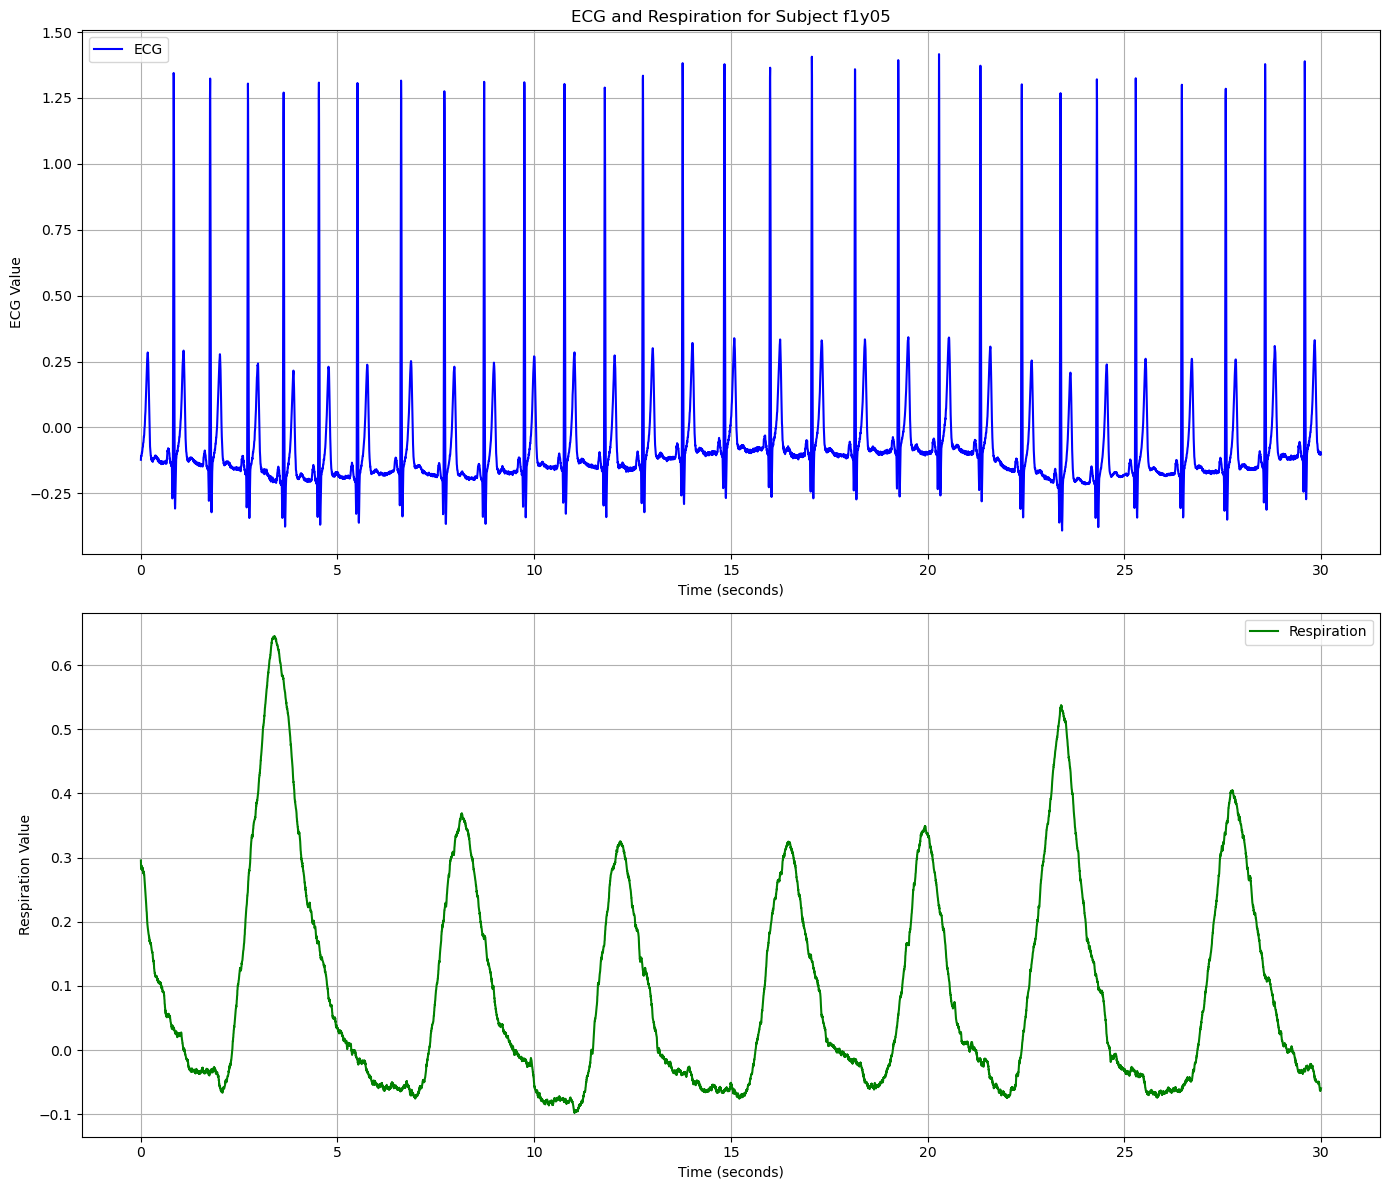

In [6]:

# Group by subject_id and choose one random subject
grouped = df.groupby('subject_id')
random_subject = np.random.choice(df['subject_id'].unique())

# Filter the dataframe for the chosen subject
#subject_df = grouped.get_group(random_subject)
subject_df = grouped.get_group('f2y02')

# Convert samples to seconds
sample_rate = 250  # 250 samples per second
time_in_seconds = subject_df['sample'].iloc[1:7500] / sample_rate

# Plot the data
plt.figure(figsize=(14, 12))

# Plot ECG data
plt.subplot(2, 1, 1)
plt.plot(time_in_seconds, subject_df['ecg'].iloc[1:7500], label='ECG', color='blue')
plt.title(f'ECG and Respiration for Subject {random_subject}')
plt.xlabel('Time (seconds)')
plt.ylabel('ECG Value')
plt.legend()
plt.grid(True)

# Plot respiration data
plt.subplot(2, 1, 2)
plt.plot(time_in_seconds, subject_df['resp'].iloc[1:7500], label='Respiration', color='green')
plt.xlabel('Time (seconds)')
plt.ylabel('Respiration Value')
plt.legend()
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()

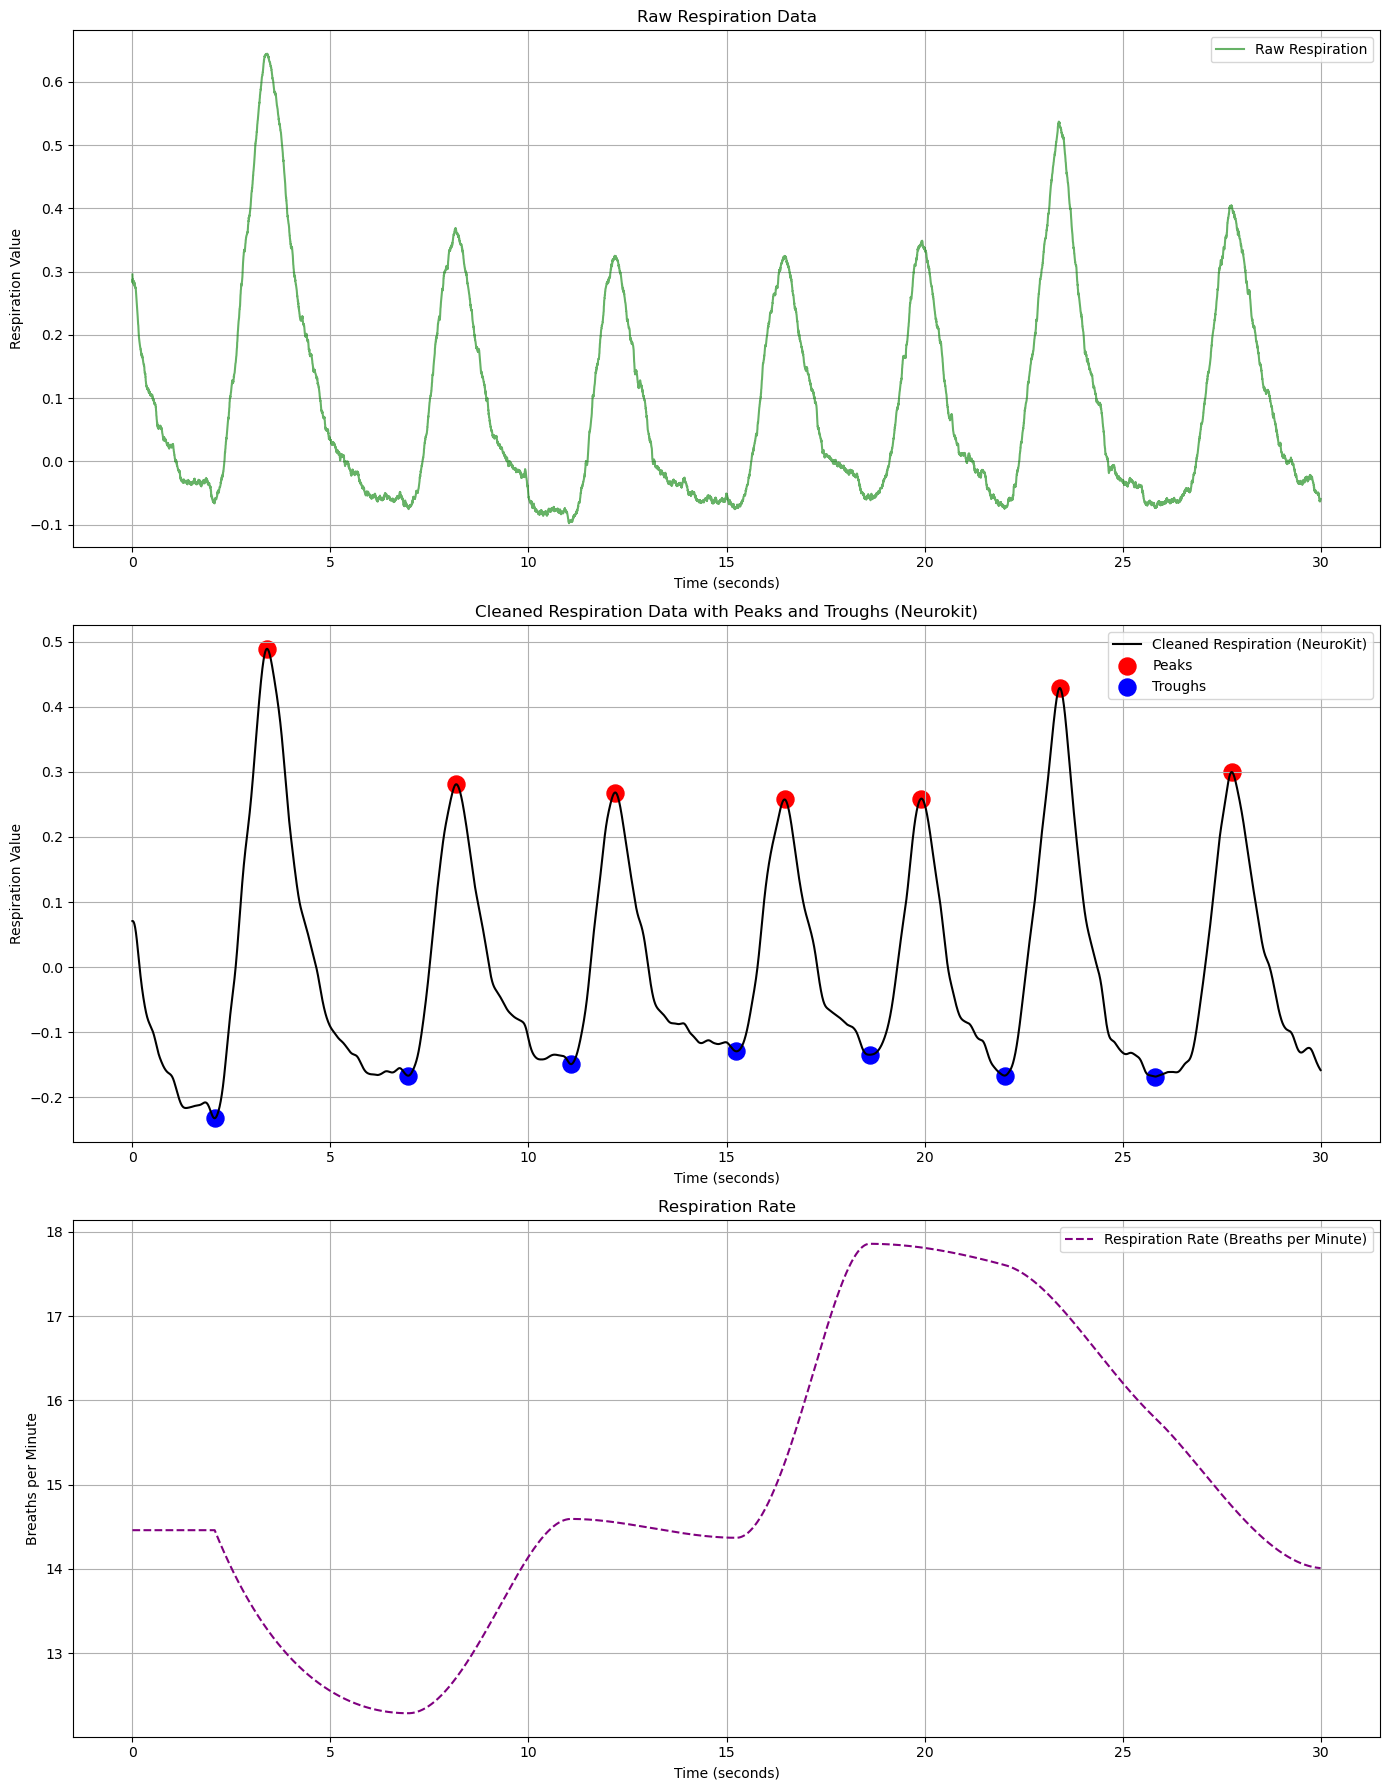

In [7]:
# Ensure the indices for slicing are within the bounds of the DataFrame
sample_rate = 250  # 250 samples per second
start_index = 1
end_index = min(7500, len(subject_df))

# Convert samples to seconds
time_in_seconds = subject_df['sample'].iloc[start_index:end_index] / sample_rate

# Respiration data for the selected range
respiration = subject_df['resp'].iloc[start_index:end_index]

# Clean and process the respiration data using nk.rsp_process
rsp_signals, rsp_info = nk.rsp_process(subject_df['resp'], sampling_rate=sample_rate, method='khodadad2018')

# Extract the cleaned respiration signal, peaks, troughs, and respiration rate
cleaned_respiration = rsp_signals["RSP_Clean"].iloc[start_index:end_index]
peaks = rsp_signals["RSP_Peaks"].iloc[start_index:end_index].values
troughs = rsp_signals["RSP_Troughs"].iloc[start_index:end_index].values
respiration_rate = rsp_signals["RSP_Rate"].iloc[start_index:end_index].values

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(14, 18))

# Plot raw respiration data
axs[0].plot(time_in_seconds, respiration, label='Raw Respiration', color='green', alpha=0.6)
axs[0].set_title('Raw Respiration Data')
axs[0].set_xlabel('Time (seconds)')
axs[0].set_ylabel('Respiration Value')
axs[0].legend()
axs[0].grid(True)

# Plot cleaned respiration data with peaks and troughs
axs[1].plot(time_in_seconds, cleaned_respiration, label='Cleaned Respiration (NeuroKit)', color='black')
axs[1].scatter(time_in_seconds[peaks == 1], cleaned_respiration[peaks == 1], color='red', marker='o', s=150, label='Peaks')
axs[1].scatter(time_in_seconds[troughs == 1], cleaned_respiration[troughs == 1], color='blue', marker='o', s=150, label='Troughs')
axs[1].set_title('Cleaned Respiration Data with Peaks and Troughs (Neurokit)')
axs[1].set_xlabel('Time (seconds)')
axs[1].set_ylabel('Respiration Value')
axs[1].legend()
axs[1].grid(True)

# Plot respiration rate
axs[2].plot(time_in_seconds, respiration_rate, label='Respiration Rate (Breaths per Minute)', color='purple', linestyle='--')
axs[2].set_title('Respiration Rate')
axs[2].set_xlabel('Time (seconds)')
axs[2].set_ylabel('Breaths per Minute')
axs[2].legend()
axs[2].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

In [8]:
rsp_signals

,RSP_Raw,RSP_Clean,RSP_Amplitude,RSP_Rate,RSP_RVT,RSP_Phase,RSP_Phase_Completion,RSP_Symmetry_PeakTrough,RSP_Symmetry_RiseDecay,RSP_Peaks,RSP_Troughs
0,0.272499,0.070706,0.721436,14.457910,0.045393,NaN,0.0,0.740522,0.270270,0,0
1,0.295558,0.070791,0.721436,14.457910,0.045401,NaN,0.0,0.740522,0.270270,0,0
2,0.282928,0.070825,0.721436,14.457910,0.045410,NaN,0.0,0.740522,0.270270,0,0
3,0.288274,0.070801,0.721436,14.457910,0.045420,NaN,0.0,0.740522,0.270270,0,0
4,0.282781,0.070713,0.721436,14.457910,0.045431,NaN,0.0,0.740522,0.270270,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1758649,0.136491,0.003134,0.461045,7.194245,0.146534,NaN,0.0,0.626943,0.154436,0,0
1758650,0.141801,0.002736,0.461045,7.194245,0.146583,NaN,0.0,0.626943,0.154436,0,0
1758651,0.136319,0.002366,0.461045,7.194245,0.146631,NaN,0.0,0.626943,0.154436,0,0
1758652,0.143035,0.002024,0.461045,7.194245,0.146679,NaN,0.0,0.626943,0.154436,0,0


In [9]:
subject_df

,ecg,resp,subject_id,sample,sample_rate
69453808,-0.113317,0.272499,f2y02,0,250
69453809,-0.122618,0.295558,f2y02,1,250
69453810,-0.107639,0.282928,f2y02,2,250
69453811,-0.109123,0.288274,f2y02,3,250
69453812,-0.107145,0.282781,f2y02,4,250
...,...,...,...,...,...
71212457,-0.059550,0.136491,f2y02,1758649,250
71212458,-0.064602,0.141801,f2y02,1758650,250
71212459,-0.057322,0.136319,f2y02,1758651,250
71212460,-0.051296,0.143035,f2y02,1758652,250


In [10]:
rsp_info

{'RSP_Peaks': array([    850,    2044,    3048, ..., 1754288, 1755235, 1757358]),
 'RSP_Troughs': array([    520,    1741,    2769, ..., 1753932, 1754913, 1756998]),
 'sampling_rate': 250}

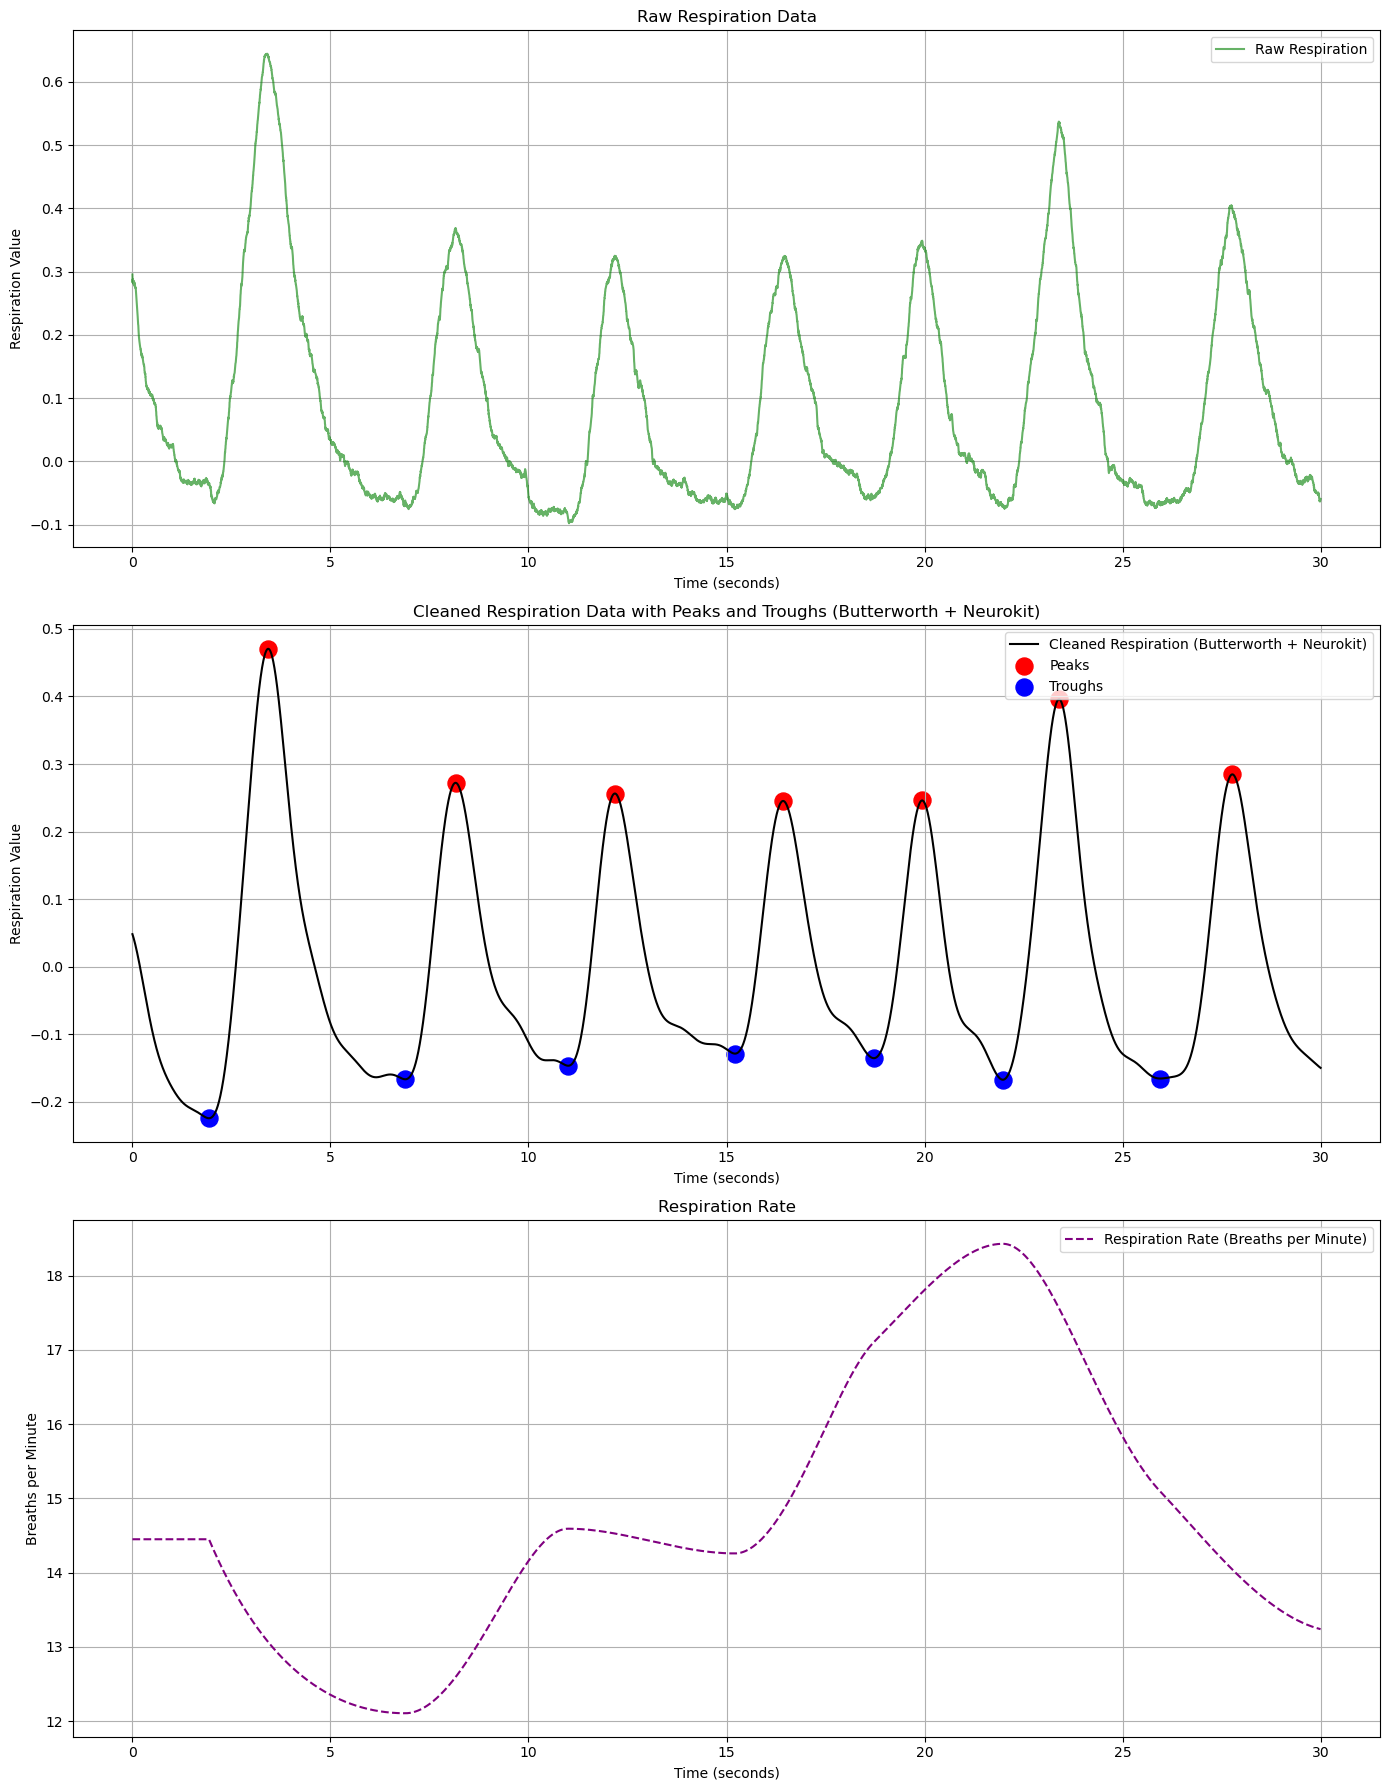

In [11]:
# Ensure the indices for slicing are within the bounds of the DataFrame
sample_rate = 250  # 250 samples per second
start_index = 1
end_index = min(7500, len(subject_df))

# Convert samples to seconds
time_in_seconds = subject_df['sample'][start_index:end_index] / sample_rate

# Respiration data for the selected range
respiration = subject_df['resp'][start_index:end_index]

# Apply a low-pass Butterworth filter to the respiration data
def low_pass_filter(data, cutoff_freq, sample_rate):
    nyquist = 0.5 * sample_rate
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(4, normal_cutoff, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

cutoff_frequency = 1  # Set the cutoff frequency to 1 Hz
filtered_respiration = low_pass_filter(subject_df['resp'], cutoff_frequency, sample_rate)

# Clean and process the filtered respiration data using nk.rsp_process
rsp_signals, rsp_info = nk.rsp_process(filtered_respiration, sampling_rate=sample_rate, method='khodadad2018')

# Extract the cleaned respiration signal, peaks, troughs, and respiration rate
cleaned_respiration = rsp_signals["RSP_Clean"].iloc[start_index:end_index]
peaks = rsp_signals["RSP_Peaks"].iloc[start_index:end_index].values
troughs = rsp_signals["RSP_Troughs"].iloc[start_index:end_index].values
respiration_rate = rsp_signals["RSP_Rate"].iloc[start_index:end_index].values

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(14, 18))

# Plot raw respiration data
axs[0].plot(time_in_seconds, respiration, label='Raw Respiration', color='green', alpha=0.6)
axs[0].set_title('Raw Respiration Data')
axs[0].set_xlabel('Time (seconds)')
axs[0].set_ylabel('Respiration Value')
axs[0].legend()
axs[0].grid(True)

# Plot cleaned respiration data with peaks and troughs
axs[1].plot(time_in_seconds, cleaned_respiration, label='Cleaned Respiration (Butterworth + Neurokit)', color='black')
axs[1].scatter(time_in_seconds[peaks == 1], cleaned_respiration[peaks == 1], color='red', marker='o', s=150, label='Peaks')
axs[1].scatter(time_in_seconds[troughs == 1], cleaned_respiration[troughs == 1], color='blue', marker='o', s=150, label='Troughs')
axs[1].set_title('Cleaned Respiration Data with Peaks and Troughs (Butterworth + Neurokit)')
axs[1].set_xlabel('Time (seconds)')
axs[1].set_ylabel('Respiration Value')
axs[1].legend()
axs[1].grid(True)

# Plot respiration rate
axs[2].plot(time_in_seconds, respiration_rate, label='Respiration Rate (Breaths per Minute)', color='purple', linestyle='--')
axs[2].set_title('Respiration Rate')
axs[2].set_xlabel('Time (seconds)')
axs[2].set_ylabel('Breaths per Minute')
axs[2].legend()
axs[2].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


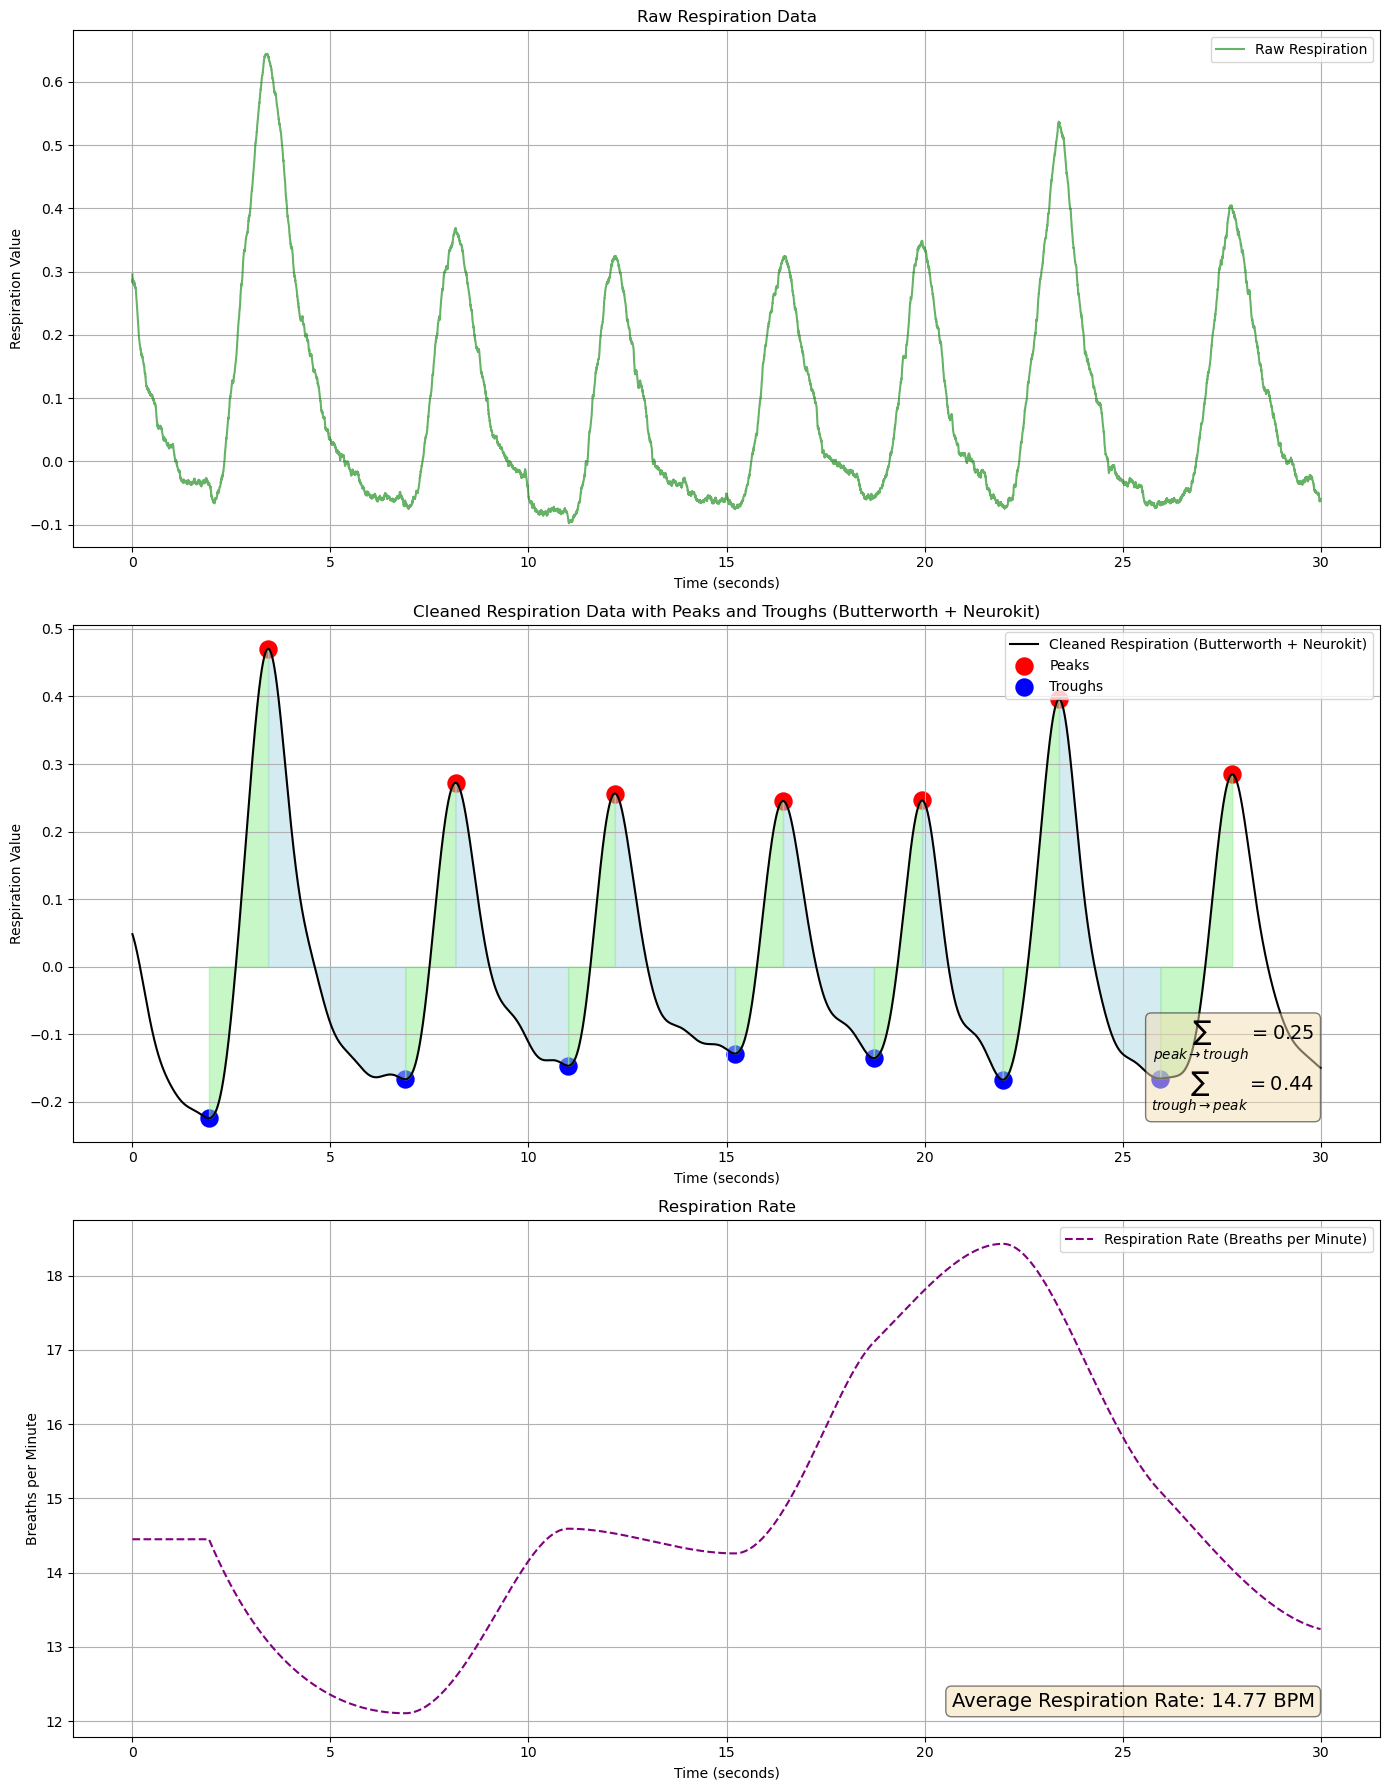

Shaded Areas from Peak to Next Trough: [-0.0275835313031218, -0.06877921592066386, -0.08968710408738607, -0.0067843210969271844, -0.04571724353389725, -0.01094343535844522]
Shaded Areas from Trough to Next Peak: [0.12323244601202704, 0.039823044747921046, 0.04139428028045737, 0.04984808362360308, 0.03768956260192258, 0.11123362463095748, -0.03195949305541389]


In [12]:
# Ensure the indices for slicing are within the bounds of the DataFrame
sample_rate = 250  # 250 samples per second
start_index = 1
end_index = min(7500, len(subject_df))

# Convert samples to seconds
time_in_seconds = subject_df['sample'].iloc[start_index:end_index] / sample_rate

# Respiration data for the selected range
respiration = subject_df['resp'].iloc[start_index:end_index]

# Apply a low-pass Butterworth filter to the respiration data
def low_pass_filter(data, cutoff_freq, sample_rate):
    nyquist = 0.5 * sample_rate
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(4, normal_cutoff, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

cutoff_frequency = 1  # Set the cutoff frequency to 1 Hz
filtered_respiration = low_pass_filter(subject_df['resp'], cutoff_frequency, sample_rate)

# Clean and process the filtered respiration data using nk.rsp_process
rsp_signals, rsp_info = nk.rsp_process(filtered_respiration, sampling_rate=sample_rate, method='khodadad2018')

# Extract the cleaned respiration signal, peaks, troughs, and respiration rate
cleaned_respiration = rsp_signals["RSP_Clean"][start_index:end_index]
peaks = rsp_signals["RSP_Peaks"][start_index:end_index].values
troughs = rsp_signals["RSP_Troughs"][start_index:end_index].values
respiration_rate = rsp_signals["RSP_Rate"][start_index:end_index].values

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(14, 18))

# Plot raw respiration data
axs[0].plot(time_in_seconds, respiration, label='Raw Respiration', color='green', alpha=0.6)
axs[0].set_title('Raw Respiration Data')
axs[0].set_xlabel('Time (seconds)')
axs[0].set_ylabel('Respiration Value')
axs[0].legend()
axs[0].grid(True)

# Plot cleaned respiration data with peaks and troughs
axs[1].plot(time_in_seconds, cleaned_respiration, label='Cleaned Respiration (Butterworth + Neurokit)', color='black')
axs[1].scatter(time_in_seconds[peaks == 1], cleaned_respiration[peaks == 1], color='red', marker='o', s=150, label='Peaks')
axs[1].scatter(time_in_seconds[troughs == 1], cleaned_respiration[troughs == 1], color='blue', marker='o', s=150, label='Troughs')

# Calculate and shade tidal volumes
shaded_areas_peak_to_trough = []
shaded_areas_trough_to_peak = []

for i in range(1, len(peaks)):
    if peaks[i] == 1 and i < len(troughs) - 1 and troughs[i] == 0:
        # Shade area from peak to next trough
        next_trough_idx = np.where(troughs[i:] == 1)[0]
        if next_trough_idx.size > 0:
            next_trough_idx = next_trough_idx[0] + i
            axs[1].fill_between(time_in_seconds[i:next_trough_idx], 0, cleaned_respiration[i:next_trough_idx], color='lightblue', alpha=0.5)
            area = np.trapz(cleaned_respiration[i:next_trough_idx], time_in_seconds[i:next_trough_idx])
            shaded_areas_peak_to_trough.append(area)
    elif troughs[i] == 1 and i < len(peaks) - 1 and peaks[i] == 0:
        # Shade area from trough to next peak
        next_peak_idx = np.where(peaks[i:] == 1)[0]
        if next_peak_idx.size > 0:
            next_peak_idx = next_peak_idx[0] + i
            axs[1].fill_between(time_in_seconds[i:next_peak_idx], 0, cleaned_respiration[i:next_peak_idx], color='lightgreen', alpha=0.5)
            area = np.trapz(cleaned_respiration[i:next_peak_idx], time_in_seconds[i:next_peak_idx])
            shaded_areas_trough_to_peak.append(area)

# Sum the absolute values of shaded areas
sum_peak_to_trough = np.sum(np.abs(shaded_areas_peak_to_trough))
sum_trough_to_peak = np.sum(np.abs(shaded_areas_trough_to_peak))

# Display the sums as text in the second subplot
textstr = '\n'.join((
    r'$\sum_{peak \rightarrow trough}=%.2f$' % (sum_peak_to_trough,),
    r'$\sum_{trough \rightarrow peak}=%.2f$' % (sum_trough_to_peak,)
))

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
axs[1].text(0.95, 0.05, textstr, transform=axs[1].transAxes, fontsize=14,
            verticalalignment='bottom', horizontalalignment='right', bbox=props)

axs[1].set_title('Cleaned Respiration Data with Peaks and Troughs (Butterworth + Neurokit)')
axs[1].set_xlabel('Time (seconds)')
axs[1].set_ylabel('Respiration Value')
axs[1].legend()
axs[1].grid(True)

# Calculate and annotate the average respiration rate
average_respiration_rate = np.mean(respiration_rate)
textstr_rate = f'Average Respiration Rate: {average_respiration_rate:.2f} BPM'
props_rate = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
axs[2].text(0.95, 0.05, textstr_rate, transform=axs[2].transAxes, fontsize=14,
            verticalalignment='bottom', horizontalalignment='right', bbox=props_rate)

# Plot respiration rate
axs[2].plot(time_in_seconds, respiration_rate, label='Respiration Rate (Breaths per Minute)', color='purple', linestyle='--')
axs[2].set_title('Respiration Rate')
axs[2].set_xlabel('Time (seconds)')
axs[2].set_ylabel('Breaths per Minute')
axs[2].legend()
axs[2].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

# Print the shaded areas
print("Shaded Areas from Peak to Next Trough:", shaded_areas_peak_to_trough)
print("Shaded Areas from Trough to Next Peak:", shaded_areas_trough_to_peak)



In [13]:
def calculate_respiration_metrics(respiration_data, sample_rate=250, cutoff_frequency=1):
    """
    Calculate respiration metrics including mean respiration rate, areas from peak to trough, and trough to peak.
    
    Args:
    - respiration_data (array-like): The respiration signal data.
    - sample_rate (int): The sampling rate of the data.
    - cutoff_frequency (int): The cutoff frequency for the low-pass filter.
    
    Returns:
    - dict: A dictionary containing mean respiration rate, areas from peak to trough, and trough to peak.
    """
    
    # Apply low-pass Butterworth filter
    def low_pass_filter(data, cutoff_freq, sample_rate):
        nyquist = 0.5 * sample_rate
        normal_cutoff = cutoff_freq / nyquist
        b, a = butter(4, normal_cutoff, btype='low', analog=False)
        filtered_data = filtfilt(b, a, data)
        return filtered_data

    filtered_respiration = low_pass_filter(respiration_data, cutoff_frequency, sample_rate)

    # Clean and process the filtered respiration data
    rsp_signals, rsp_info = nk.rsp_process(filtered_respiration, sampling_rate=sample_rate, method='khodadad2018')
    cleaned_respiration = rsp_signals["RSP_Clean"]
    peaks = rsp_signals["RSP_Peaks"].values
    troughs = rsp_signals["RSP_Troughs"].values
    respiration_rate = rsp_signals["RSP_Rate"].values

    # Calculate mean respiration rate
    mean_respiration_rate = np.mean(respiration_rate)

    # Calculate the areas for peak-to-trough and trough-to-peak transitions and average latency
    shaded_areas_peak_to_trough = []
    shaded_areas_trough_to_peak = []
    
    latency_peak_to_trough = []
    latency_trough_to_peak = []
    
    for i in range(1, len(cleaned_respiration)):
        if peaks[i] == 1 and i < len(troughs) - 1:
            # Find the next trough index after this peak
            next_trough_idx = np.where(troughs[i:] == 1)[0]
            if next_trough_idx.size > 0:
                next_trough_idx = next_trough_idx[0] + i
                area = np.trapz(cleaned_respiration.iloc[i:next_trough_idx], dx=1/sample_rate)
                shaded_areas_peak_to_trough.append(area)
                
                latency = (next_trough_idx - i) / sample_rate
                latency_peak_to_trough.append(latency)

                
        elif troughs[i] == 1 and i < len(peaks) - 1:
            # Find the next peak index after this trough
            next_peak_idx = np.where(peaks[i:] == 1)[0]
            if next_peak_idx.size > 0:
                next_peak_idx = next_peak_idx[0] + i
                area = np.trapz(cleaned_respiration.iloc[i:next_peak_idx], dx=1/sample_rate)
                shaded_areas_trough_to_peak.append(area)
                
                latency = (next_peak_idx - i) / sample_rate
                latency_trough_to_peak.append(latency)

                
    sum_peak_to_trough = np.sum(np.abs(shaded_areas_peak_to_trough))
    sum_trough_to_peak = np.sum(np.abs(shaded_areas_trough_to_peak))
    average_latency_peak_to_trough = np.mean(latency_peak_to_trough)
    average_latency_trough_to_peak = np.mean(latency_trough_to_peak)
    # Return the calculated metrics
    return {
        "Mean Respiration Rate": mean_respiration_rate,
        "Total Area Peak to Trough": sum_peak_to_trough,
        "Total Area Trough to Peak": sum_trough_to_peak,
        "Average time Peak to Trough": average_latency_peak_to_trough,
        "Average time Trough to Peak": average_latency_trough_to_peak,
    }


In [14]:
def get_ecg_features(ecg, time_in_sec, fs):
    """
    Compute ECG features from raw ECG signal.

    Parameters
    ----------
    ecg : array-like
        Raw ECG signal.
    time_in_sec : array-like
        Timestamps corresponding to each sample of the ECG signal.
    fs : float
        Sampling frequency of the ECG signal.

    Returns
    -------
    array
        Array of ECG features: [mean heart rate, maximum heart rate, minimum heart rate, heart rate variability].
    """
    try:
        b, a = butter(4, (0.25, 25), 'bandpass', fs=fs)
        ecg_filt = filtfilt(b, a, ecg, axis=0)
        ecg_cleaned = nk.ecg_clean(ecg_filt, sampling_rate=fs)
        instant_peaks, rpeaks = nk.ecg_peaks(ecg_cleaned, sampling_rate=fs,method="engzeemod2012")
    except Exception as e:
        raise ValueError("Error processing ECG signal: " + str(e))

    rr_times = time_in_sec[rpeaks['ECG_R_Peaks']]
    if len(rr_times) == 0:
        raise ValueError("No R-peaks detected in ECG signal.")
    
    # Assuming d_rr contains the time intervals between successive heartbeats in seconds
    d_rr = np.diff(rr_times)
    heart_rate = 60 / d_rr
    if heart_rate.size == 0:
        raise ValueError("Error computing heart rate from ECG signal.")
    
    valid_heart_rate = heart_rate[~np.isnan(heart_rate)]
    z_scores = np.abs(stats.zscore(valid_heart_rate))

    # Define a z-score threshold beyond which a value is considered an outlier
    z_score_threshold = 4.0

    # Remove outliers from the valid_heart_rate array
    heart_rate = valid_heart_rate[z_scores <= z_score_threshold]

    hr_mean = np.nanmean(heart_rate)
    hr_min = np.nanmin(heart_rate)
    hr_max = np.nanmax(heart_rate)
    d_rr_ms = 1000 * d_rr
    d_d_rr_ms = np.diff(d_rr_ms)

    valid_d_d_rr_ms = d_d_rr_ms[~np.isnan(d_d_rr_ms)] 
    z_scores = np.abs(stats.zscore(valid_d_d_rr_ms))
    d_d_rr_ms= valid_d_d_rr_ms[z_scores <= z_score_threshold]
    heart_rate_variability = np.sqrt(np.nanmean(np.square(d_d_rr_ms)))

    # Create a new signal 'ecg_with_rr_intervals' with RR intervals and a 1-second window around each RR interval
    ecg_with_rr_intervals = []
    ecg_with_rr_intervals_cleaned = []

    for rr_interval in rr_times:
        start_time = rr_interval - 0.1 # 1 second before the RR interval
        end_time = rr_interval + 0.1   # 1 second after the RR interval
        indices = np.where((time_in_sec >= start_time) & (time_in_sec <= end_time))[0]

        # Validate indices to ensure they are within bounds
        indices = indices[(indices >= 0) & (indices < len(ecg))]

        if len(indices) > 0:
            ecg_with_rr_intervals.extend(ecg[indices])
            ecg_with_rr_intervals_cleaned.extend(ecg_cleaned[indices])

    # Convert lists to NumPy arrays
    ecg_with_rr_intervals = np.array(ecg_with_rr_intervals)
    ecg_with_rr_intervals_cleaned = np.array(ecg_with_rr_intervals_cleaned)

    # Calculate noise power (mean squared amplitude of noise)
    signal_power = np.var(ecg_with_rr_intervals)
    noise_power = np.var(ecg_with_rr_intervals - ecg_with_rr_intervals_cleaned)

    # Calculate noise power (mean squared amplitude of noise)
    #signal_power = np.var(ecg)
    #noise_power = np.var(ecg - ecg_cleaned)

     # Calculate SNR in dB and append it to the array
    snr_values = 10 * np.log10(signal_power / noise_power)
    
    return hr_mean, hr_max, hr_min, heart_rate_variability, snr_values

In [15]:
calculate_respiration_metrics(subject_df['resp'].iloc[start_index:end_index],sample_rate=250, cutoff_frequency=1)

{'Mean Respiration Rate': 15.622901954070029,
 'Total Area Peak to Trough': 0.30913062665294605,
 'Total Area Trough to Peak': 0.3306151184888064,
 'Average time Peak to Trough': 2.7359999999999998,
 'Average time Trough to Peak': 1.298}

In [16]:
SAMPLE_RATE = 250
length = len(subject_df['ecg'].iloc[start_index:end_index])
hr_mean, hr_max, hr_min, heart_rate_variability, snr_values = get_ecg_features(subject_df['ecg'].iloc[start_index:end_index].reset_index(drop=True), np.arange(0,length/SAMPLE_RATE,1/SAMPLE_RATE), fs=SAMPLE_RATE)
print(f"{hr_mean},  {hr_max},  {hr_min}, {heart_rate_variability}, {snr_values}")

58.42193555618593,  66.96428571428572,  51.19453924914673, 72.52483610358522, 10.625128583784662


In [17]:
type(subject_df['resp'].iloc[start_index:end_index])

pandas.core.series.Series

# Modelling

In [18]:
CHUCK_SIZE = 30 * 250 #60 second * 250 Hz

In [19]:
df

,ecg,resp,subject_id,sample,sample_rate
0,7.952000,8.000000,f1y01,0,250
1,7.936000,8.044000,f1y01,1,250
2,8.004000,8.000000,f1y01,2,250
3,8.064000,8.052000,f1y01,3,250
4,7.980000,8.012000,f1y01,4,250
...,...,...,...,...,...
71212457,-0.059550,0.136491,f2y02,1758649,250
71212458,-0.064602,0.141801,f2y02,1758650,250
71212459,-0.057322,0.136319,f2y02,1758651,250
71212460,-0.051296,0.143035,f2y02,1758652,250


In [20]:
df['sample_rate'].unique()

array([250])

In [21]:
import pandas as pd

# Function to split the data into chunks of a specified size
def split_into_chunks(group, chunk_size=CHUCK_SIZE):
    num_chunks = len(group) // chunk_size  # Calculate how many full chunks we can have
    chunks = []
    for i in range(num_chunks):
        start = i * chunk_size
        end = start + chunk_size
        chunks.append({
            'ecg': group['ecg'].iloc[start:end].tolist(),
            'resp': group['resp'].iloc[start:end].tolist()
        })
    return chunks

# Group the DataFrame by 'subject_id'
grouped = df.groupby('subject_id')

# Dictionary to hold the chunks for each subject
subject_chunks = {}

# Loop through each group, split into chunks, and store in the dictionary
for subject_id, group in grouped:
    subject_chunks[subject_id] = split_into_chunks(group)

# Flatten the dictionary into a DataFrame
# Initialize an empty list to hold all chunk records
chunk_data = []

# Iterate through each subject and their chunks
for subject_id, chunks in subject_chunks.items():
    for index, chunk in enumerate(chunks):
        chunk_data.append({
            'subject_id': subject_id,
            'chunk_id': index,
            'ecg': chunk['ecg'],
            'resp': chunk['resp']
        })

# Convert the list of dictionaries to a DataFrame
chunks_df = pd.DataFrame(chunk_data)

# Print the DataFrame structure
print(chunks_df.head())

  subject_id  chunk_id                                                ecg  \
0      f1o01         0  [8.46, 8.592, 8.352, 8.152, 8.34, 8.528, 8.312...   
1      f1o01         1  [8.316, 8.58, 8.664, 8.428, 8.264, 8.444, 8.58...   
2      f1o01         2  [8.088, 8.088, 8.26, 8.304, 8.144, 8.072, 8.2,...   
3      f1o01         3  [8.152, 8.02, 8.036, 8.208, 8.208, 8.128, 8.12...   
4      f1o01         4  [8.068, 8.004, 7.864, 7.9, 8.048, 7.996, 7.848...   

                                                resp  
0  [8.488, 8.452, 8.488, 8.496, 8.508, 8.476, 8.4...  
1  [8.116, 8.124, 8.092, 8.088, 8.06, 8.064, 8.07...  
2  [8.656, 8.624, 8.608, 8.596, 8.648, 8.652, 8.6...  
3  [8.672, 8.684, 8.648, 8.632, 8.628, 8.672, 8.6...  
4  [8.548, 8.524, 8.508, 8.528, 8.568, 8.552, 8.5...  


In [22]:
chunks_df

,subject_id,chunk_id,ecg,resp
0,f1o01,0,"[8.46, 8.592, 8.352, 8.152, 8.34, 8.528, 8.312...","[8.488, 8.452, 8.488, 8.496, 8.508, 8.476, 8.4..."
1,f1o01,1,"[8.316, 8.58, 8.664, 8.428, 8.264, 8.444, 8.58...","[8.116, 8.124, 8.092, 8.088, 8.06, 8.064, 8.07..."
2,f1o01,2,"[8.088, 8.088, 8.26, 8.304, 8.144, 8.072, 8.2,...","[8.656, 8.624, 8.608, 8.596, 8.648, 8.652, 8.6..."
3,f1o01,3,"[8.152, 8.02, 8.036, 8.208, 8.208, 8.128, 8.12...","[8.672, 8.684, 8.648, 8.632, 8.628, 8.672, 8.6..."
4,f1o01,4,"[8.068, 8.004, 7.864, 7.9, 8.048, 7.996, 7.848...","[8.548, 8.524, 8.508, 8.528, 8.568, 8.552, 8.5..."
...,...,...,...,...
9471,f2y10,234,"[-0.01708984375, -0.01220703125, -0.01953125, ...","[0.54443359375, 0.5419921875, 0.5517578125, 0...."
9472,f2y10,235,"[-0.1220703125, -0.23681640625, -0.25390625, -...","[-0.17333984375, -0.1708984375, -0.17333984375..."
9473,f2y10,236,"[0.1025390625, 0.07568359375, 0.0439453125, 0....","[-0.185546875, -0.185546875, -0.1806640625, -0..."
9474,f2y10,237,"[-0.1123046875, -0.107421875, -0.10986328125, ...","[0.0830078125, 0.087890625, 0.0927734375, 0.09..."


In [23]:
len(chunks_df)

9476

In [24]:
chunks_df = chunks_df[chunks_df['resp'].apply(len) == CHUCK_SIZE]
chunks_df = chunks_df[chunks_df['ecg'].apply(len) == CHUCK_SIZE]

In [25]:
len(chunks_df )

9476

In [26]:
chunks_df.head()

,subject_id,chunk_id,ecg,resp
0,f1o01,0,"[8.46, 8.592, 8.352, 8.152, 8.34, 8.528, 8.312...","[8.488, 8.452, 8.488, 8.496, 8.508, 8.476, 8.4..."
1,f1o01,1,"[8.316, 8.58, 8.664, 8.428, 8.264, 8.444, 8.58...","[8.116, 8.124, 8.092, 8.088, 8.06, 8.064, 8.07..."
2,f1o01,2,"[8.088, 8.088, 8.26, 8.304, 8.144, 8.072, 8.2,...","[8.656, 8.624, 8.608, 8.596, 8.648, 8.652, 8.6..."
3,f1o01,3,"[8.152, 8.02, 8.036, 8.208, 8.208, 8.128, 8.12...","[8.672, 8.684, 8.648, 8.632, 8.628, 8.672, 8.6..."
4,f1o01,4,"[8.068, 8.004, 7.864, 7.9, 8.048, 7.996, 7.848...","[8.548, 8.524, 8.508, 8.528, 8.568, 8.552, 8.5..."


In [ ]:
SAMPLE_RATE = 250
CUT_OFF_SNR = 5

snr_list = []
# Pre-define new columns for calculated metrics
chunks_df['Mean_Respiration_Rate'] = np.nan
chunks_df['Total_Area_Peak_to_Trough'] = np.nan
chunks_df['Total_Area_Trough_to_Peak'] = np.nan
chunks_df['Mean_latency_Trough_to_Peak'] = np.nan
chunks_df['Mean_latency_Peak_to_Trough'] = np.nan
chunks_df['hr_min'] = np.nan
chunks_df['hr_mean'] = np.nan
chunks_df['hr_max'] = np.nan
chunks_df['hrv'] = np.nan
chunks_df['snr'] = np.nan


# List to track indices of rows that cause errors
error_indices = []

for idx, row in chunks_df.iterrows():
    print(idx)
        
    try:
        hr_mean, hr_max, hr_min, heart_rate_variability, snr_values = get_ecg_features(pd.Series(row['ecg']), np.arange(0,len(row['ecg'])/SAMPLE_RATE,1/SAMPLE_RATE), fs=SAMPLE_RATE)
        snr_list.append(snr_values)
        if snr_values < CUT_OFF_SNR:
            continue
            
        # Try to calculate respiration metrics for the current row
        results = calculate_respiration_metrics(row['resp'])
        chunks_df.at[idx, 'Mean_Respiration_Rate'] = results['Mean Respiration Rate']
        chunks_df.at[idx, 'Total_Area_Trough_to_Peak'] = results['Total Area Trough to Peak']
        chunks_df.at[idx, 'Total_Area_Peak_to_Trough'] = results['Total Area Peak to Trough']
        chunks_df.at[idx, 'Mean_latency_Trough_to_Peak'] = results['Average time Trough to Peak']
        chunks_df.at[idx, 'Mean_latency_Peak_to_Trough'] = results['Average time Peak to Trough']
        chunks_df.at[idx, 'hr_min'] = hr_min
        chunks_df.at[idx, 'hr_mean'] = hr_mean
        chunks_df.at[idx, 'hr_max'] = hr_max
        chunks_df.at[idx, 'hrv'] = heart_rate_variability
        chunks_df.at[idx, 'snr'] = snr_values

    except Exception as e:
        # Log error and mark index for potential removal
        print(f"Error processing row {idx}: {e}")
        error_indices.append(idx)

# Optionally, drop rows that caused errors from the DataFrame
chunks_df = chunks_df.drop(index=error_indices)

# Print updated DataFrame structure or save it to a file
print(chunks_df.head())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
34
36


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
63
64
65
66
67
68
69
70
71


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


98
99
101
102
104


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


105
106
107


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


125
127
128


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


129
130
131
132
133
134
135
136
137
141
142
143
144


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


145
146
147
148
149
151


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


197
198
199
200
201
202
203
204
205
206
207
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


234
236
237
238
239
241
242
243
244


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


245
246
247
249
250
251


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
355
356
357
358
359
360
361
362
363
364


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


366
368
369
370
371
372
373
374
375
377
378


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


379
380
381
382
383
384
385
386


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


442
443
444
445
446
447
448
449
450
451
452
453
454
456
457
458
459
460
461
462
463
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
481
484


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


712
713


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


714
716
717
718
719
720
721
722


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


723
724
725
726
727
728
729
730
731
734
735
736
737
738
739
740
741
742
743
744
745
746


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


748
749
750
751
752
753


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


754
757
758
759
760
761


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


762
763
764
765
766
767
768
769
770
771


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


775
776
777
780
782
783
785
786
787


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


788
790
791
792
793
794
796
797


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


798
799
800
801
804
805
807
808
810
811
812
813
814
815
816
818
819
820
821
822
823
826
827
828
829
830
832
833
834
835
836
837
838


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


839
840
841
842
843
844
845
846
847
849
850
851
852
853
854
855
857
860
861
862
863
864
865
866
868
869
870
871
872
873


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


874
877
878
879
880
881
882
884
893
894
895
896
901
902
903
904
905
906
907
908
909
910
913
916
918
920
921
924
925


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


926
927
928
929
930


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


931
932
933


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


935
936
937
938
939


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


940
941
942


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


943
945


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


946
947
948
949
951


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


952
953
954
955
956
957
958
962
964
965
966
967
968
969
970


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


971
972
973


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


974
975
976


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


977
978
980


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


981
982
983


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


984
987


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


989
991
992


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


993
995


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


996
997
998
999
1000
1001


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1003
1004


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1006
1008
1009


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1010
1011
1012


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1013
1014
1015


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1016
1017
1018


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1019
1021
1022
1024
1028


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1029
1030
1031
1034
1035
1038


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1039
1042
1045


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1047
1055
1057


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1060
1061


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1062
1063


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1064
1066
1067


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1068
1069


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1071
1074


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1075
1076
1077


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1078
1079


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1080
1082
1085
1092
1093
1098
1099
1100


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1101
1104
1105
1109
1111
1112


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1113
1114


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1118
1120
1126
1128
1129
1131


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1132
1134
1135


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1136
1137
1139


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1145
1148
1150


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1151
1153


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1154
1155
1157


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1163
1167
1168


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1171
1172
1173
1174
1175
1176
1177
1178
1179
1180
1181
1182
1183
1184
1185
1186
1187
1188
1189
1190
1191
1192
1193
1194
1195
1196
1197
1198
1199
1200
1201
1202
1203
1204
1205
1206
1207
1208
1209
1210
1211
1212
1213
1214
1215
1216
1217
1218
1219
1220
1221
1222
1223
1224
1225
1226
1227
1228
1229
1230
1231
1232
1233
1234
1235
1236
1237
1238
1239
1240
1241
1242
1243
1244
1245
1246
1247
1248
1249
1250
1251
1252
1253
1254
1255
1256
1257
1258
1259
1260
1261
1262
1263
1264
1265
1266
1267
1268
1269
1270
1271
1272
1273
1274
1275
1276
1277
1278
1279
1280
1281
1282
1283
1284
1285
1286
1287
1288
1289
1290
1291
1292
1293
1294
1295
1296
1297
1298
1299
1300
1301
1302
1303
1304
1305
1306
1307
1308
1309
1310
1311
1312
1313
1314
1315
1316


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1317
1318
1319
1320
1321
1322
1323
1324
1325
1326
1327
1328
1329
1330
1332
1333
1334
1335
1336
1337
1338
1339
1340
1341


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1342
1343
1344
1345
1346
1347
1348
1349
1350
1351
1352
1353
1354
1355
1356
1357
1358
1359
1360
1361
1362
1363
1364
1365
1366
1367
1368
1369
1370
1371
1372
1373
1374
1375
1376
1377
1378
1379
1380
1381
1382
1383
1384
1385
1386
1387
1388
1389
1391
1392
1393
1394
1396
1397
1398
1399
1400
1401
1402
1403
1404
1405
1406
1407
1408
1409
1410
1411
1412
1413
1414
1415
1416
1417
1418
1419
1420
1421
1422
1423


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1425
1426
1427
1428
1429
1430
1431
1432


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1433
1434
1435
1437
1438
1439
1440
1441
1442
1443
1444
1445
1446
1447
1448


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1449
1450
1451


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1452
1453
1454
1455
1456
1457
1458
1459
1461


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1462
1463
1464
1465
1466
1467
1468
1469
1470


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1471
1472
1473


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1474
1475
1476
1477
1478
1480
1481
1482
1483
1484
1485


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1486
1487
1488


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1489
1490
1491
1492
1493
1494
1496
1497
1498
1499
1500
1501
1502
1503
1504


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1505
1506
1508
1509
1511


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1512
1513
1514


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1515
1516
1517
1518
1519


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1520
1521
1522
1523
1524
1525
1526
1527
1528
1529
1530
1531
1532
1533
1534


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1535
1536
1537
1538
1539
1540
1541
1542
1543
1544
1545
1546
1547
1548
1549
1550
1551
1552
1553
1554
1555


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1556
1557
1558


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1559
1560
1561
1562
1563
1564


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1565
1566
1567
1568
1569
1570


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(
/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1571
1574
1575
1577
1578


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1579
1580
1581
1582
1584
1585


/home/qdang1/.conda/envs/tf/lib/python3.12/site-packages/neurokit2/rsp/rsp_symmetry.py:90: NeuroKitWarning: Not enough peaks and troughs (signal too short?) to compute symmetry, returning nan for symmetry.
  warn(


1586
1587
1588
1589
1590
1591
1592
1593
1594
1595
1596
1597
1598
1599
1600
1601
1602
1603
1604
1605
1606
1607
1608
1609
1611
1612
1613
1617
1618
1619
1620
1621
1622


In [28]:
len(chunks_df)

9208

In [29]:
chunks_df

,subject_id,chunk_id,ecg,resp,Mean_Respiration_Rate,Total_Area_Peak_to_Trough,Total_Area_Trough_to_Peak,Mean_latency_Trough_to_Peak,Mean_latency_Peak_to_Trough,hr_min,hr_mean,hr_max,hrv,snr
0,f1o01,0,"[8.46, 8.592, 8.352, 8.152, 8.34, 8.528, 8.312...","[8.488, 8.452, 8.488, 8.496, 8.508, 8.476, 8.4...",14.505123,0.562117,1.169217,1.690667,2.544000,59.055118,62.032517,66.371681,16.625697,5.385646
1,f1o01,1,"[8.316, 8.58, 8.664, 8.428, 8.264, 8.444, 8.58...","[8.116, 8.124, 8.092, 8.088, 8.06, 8.064, 8.07...",15.780254,1.146417,0.315799,1.525143,2.221333,58.593750,62.245654,66.079295,16.559194,5.984316
2,f1o01,2,"[8.088, 8.088, 8.26, 8.304, 8.144, 8.072, 8.2,...","[8.656, 8.624, 8.608, 8.596, 8.648, 8.652, 8.6...",13.284661,0.353985,0.445506,1.772000,2.860000,57.692308,59.618603,61.728395,8.315218,6.507062
3,f1o01,3,"[8.152, 8.02, 8.036, 8.208, 8.208, 8.128, 8.12...","[8.672, 8.684, 8.648, 8.632, 8.628, 8.672, 8.6...",14.913591,0.688938,1.089432,1.680000,2.391000,32.894737,62.955495,69.124424,261.545152,6.893892
4,f1o01,4,"[8.068, 8.004, 7.864, 7.9, 8.048, 7.996, 7.848...","[8.548, 8.524, 8.508, 8.528, 8.568, 8.552, 8.5...",16.444328,0.983089,0.837500,1.479200,2.752000,57.251908,62.337664,67.264574,14.326248,5.866205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9471,f2y10,234,"[-0.01708984375, -0.01220703125, -0.01953125, ...","[0.54443359375, 0.5419921875, 0.5517578125, 0....",15.151441,0.219147,0.206771,1.567200,2.387000,49.180328,56.770476,62.761506,542.688370,6.556642
9472,f2y10,235,"[-0.1220703125, -0.23681640625, -0.25390625, -...","[-0.17333984375, -0.1708984375, -0.17333984375...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9473,f2y10,236,"[0.1025390625, 0.07568359375, 0.0439453125, 0....","[-0.185546875, -0.185546875, -0.1806640625, -0...",14.860658,0.272106,0.304594,1.684667,2.696000,50.000000,56.347270,64.655172,63.884896,7.360403
9474,f2y10,237,"[-0.1123046875, -0.107421875, -0.10986328125, ...","[0.0830078125, 0.087890625, 0.0927734375, 0.09...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
chunks_df = chunks_df.dropna(subset=['Mean_Respiration_Rate'])
chunks_df = chunks_df.dropna(subset=['Mean_latency_Trough_to_Peak'])
chunks_df = chunks_df.dropna(subset=['Mean_latency_Peak_to_Trough'])

In [31]:
len(chunks_df)

7846

In [32]:
chunks_df.head()

,subject_id,chunk_id,ecg,resp,Mean_Respiration_Rate,Total_Area_Peak_to_Trough,Total_Area_Trough_to_Peak,Mean_latency_Trough_to_Peak,Mean_latency_Peak_to_Trough,hr_min,hr_mean,hr_max,hrv,snr
0,f1o01,0,"[8.46, 8.592, 8.352, 8.152, 8.34, 8.528, 8.312...","[8.488, 8.452, 8.488, 8.496, 8.508, 8.476, 8.4...",14.505123,0.562117,1.169217,1.690667,2.544000,59.055118,62.032517,66.371681,16.625697,5.385646
1,f1o01,1,"[8.316, 8.58, 8.664, 8.428, 8.264, 8.444, 8.58...","[8.116, 8.124, 8.092, 8.088, 8.06, 8.064, 8.07...",15.780254,1.146417,0.315799,1.525143,2.221333,58.593750,62.245654,66.079295,16.559194,5.984316
2,f1o01,2,"[8.088, 8.088, 8.26, 8.304, 8.144, 8.072, 8.2,...","[8.656, 8.624, 8.608, 8.596, 8.648, 8.652, 8.6...",13.284661,0.353985,0.445506,1.772000,2.860000,57.692308,59.618603,61.728395,8.315218,6.507062
3,f1o01,3,"[8.152, 8.02, 8.036, 8.208, 8.208, 8.128, 8.12...","[8.672, 8.684, 8.648, 8.632, 8.628, 8.672, 8.6...",14.913591,0.688938,1.089432,1.680000,2.391000,32.894737,62.955495,69.124424,261.545152,6.893892
4,f1o01,4,"[8.068, 8.004, 7.864, 7.9, 8.048, 7.996, 7.848...","[8.548, 8.524, 8.508, 8.528, 8.568, 8.552, 8.5...",16.444328,0.983089,0.837500,1.479200,2.752000,57.251908,62.337664,67.264574,14.326248,5.866205


In [33]:
chunks_df.to_pickle(DATA_DIR + "fantasia_dataset_preprocessing.plk")

In [34]:
chunks_df

,subject_id,chunk_id,ecg,resp,Mean_Respiration_Rate,Total_Area_Peak_to_Trough,Total_Area_Trough_to_Peak,Mean_latency_Trough_to_Peak,Mean_latency_Peak_to_Trough,hr_min,hr_mean,hr_max,hrv,snr
0,f1o01,0,"[8.46, 8.592, 8.352, 8.152, 8.34, 8.528, 8.312...","[8.488, 8.452, 8.488, 8.496, 8.508, 8.476, 8.4...",14.505123,0.562117,1.169217,1.690667,2.544000,59.055118,62.032517,66.371681,16.625697,5.385646
1,f1o01,1,"[8.316, 8.58, 8.664, 8.428, 8.264, 8.444, 8.58...","[8.116, 8.124, 8.092, 8.088, 8.06, 8.064, 8.07...",15.780254,1.146417,0.315799,1.525143,2.221333,58.593750,62.245654,66.079295,16.559194,5.984316
2,f1o01,2,"[8.088, 8.088, 8.26, 8.304, 8.144, 8.072, 8.2,...","[8.656, 8.624, 8.608, 8.596, 8.648, 8.652, 8.6...",13.284661,0.353985,0.445506,1.772000,2.860000,57.692308,59.618603,61.728395,8.315218,6.507062
3,f1o01,3,"[8.152, 8.02, 8.036, 8.208, 8.208, 8.128, 8.12...","[8.672, 8.684, 8.648, 8.632, 8.628, 8.672, 8.6...",14.913591,0.688938,1.089432,1.680000,2.391000,32.894737,62.955495,69.124424,261.545152,6.893892
4,f1o01,4,"[8.068, 8.004, 7.864, 7.9, 8.048, 7.996, 7.848...","[8.548, 8.524, 8.508, 8.528, 8.568, 8.552, 8.5...",16.444328,0.983089,0.837500,1.479200,2.752000,57.251908,62.337664,67.264574,14.326248,5.866205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9469,f2y10,232,"[-0.10009765625, -0.09765625, -0.10009765625, ...","[0.0048828125, 0.0048828125, 0.0048828125, 0.0...",14.497019,0.197665,0.101241,1.556800,2.480000,52.631579,58.396608,66.079295,66.171494,6.985175
9470,f2y10,233,"[-0.185546875, -0.1806640625, -0.18310546875, ...","[-0.126953125, -0.12939453125, -0.126953125, -...",12.471924,0.304567,0.516003,1.549600,3.345000,51.369863,58.250585,65.789474,56.823614,7.723637
9471,f2y10,234,"[-0.01708984375, -0.01220703125, -0.01953125, ...","[0.54443359375, 0.5419921875, 0.5517578125, 0....",15.151441,0.219147,0.206771,1.567200,2.387000,49.180328,56.770476,62.761506,542.688370,6.556642
9473,f2y10,236,"[0.1025390625, 0.07568359375, 0.0439453125, 0....","[-0.185546875, -0.185546875, -0.1806640625, -0...",14.860658,0.272106,0.304594,1.684667,2.696000,50.000000,56.347270,64.655172,63.884896,7.360403


In [35]:
len(snr_list)

9223

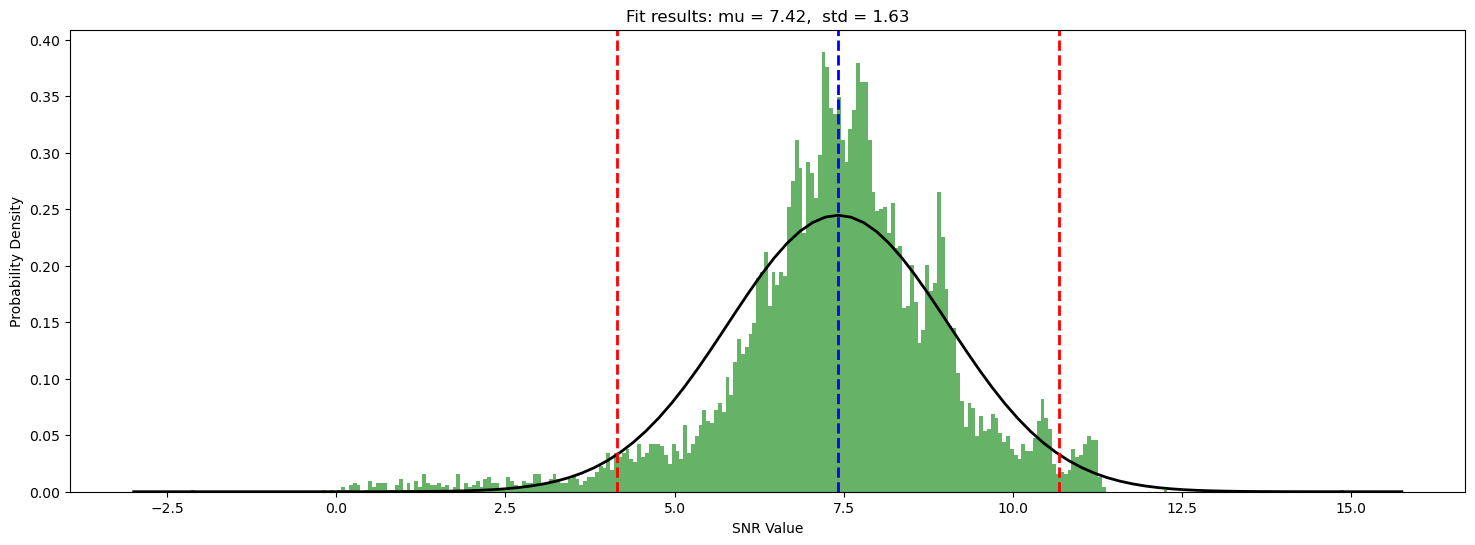

In [36]:
from scipy.stats import norm

# Plot the histogram
plt.figure(figsize=(18,6))
count, bins, ignored = plt.hist(snr_list, bins=300, density=True, alpha=0.6, color='g')

# Fit a normal distribution to the data
mu, std = norm.fit(snr_list)

# Plot the Gaussian distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.axvline(mu , color='blue', linestyle='dashed', linewidth=2)
plt.axvline(mu - 2*std, color='r', linestyle='dashed', linewidth=2)
plt.axvline(mu + 2*std, color='r', linestyle='dashed', linewidth=2)

title = f"Fit results: mu = {mu:.2f},  std = {std:.2f}"
plt.title(title)

plt.xlabel('SNR Value')
plt.ylabel('Probability Density')
plt.show()

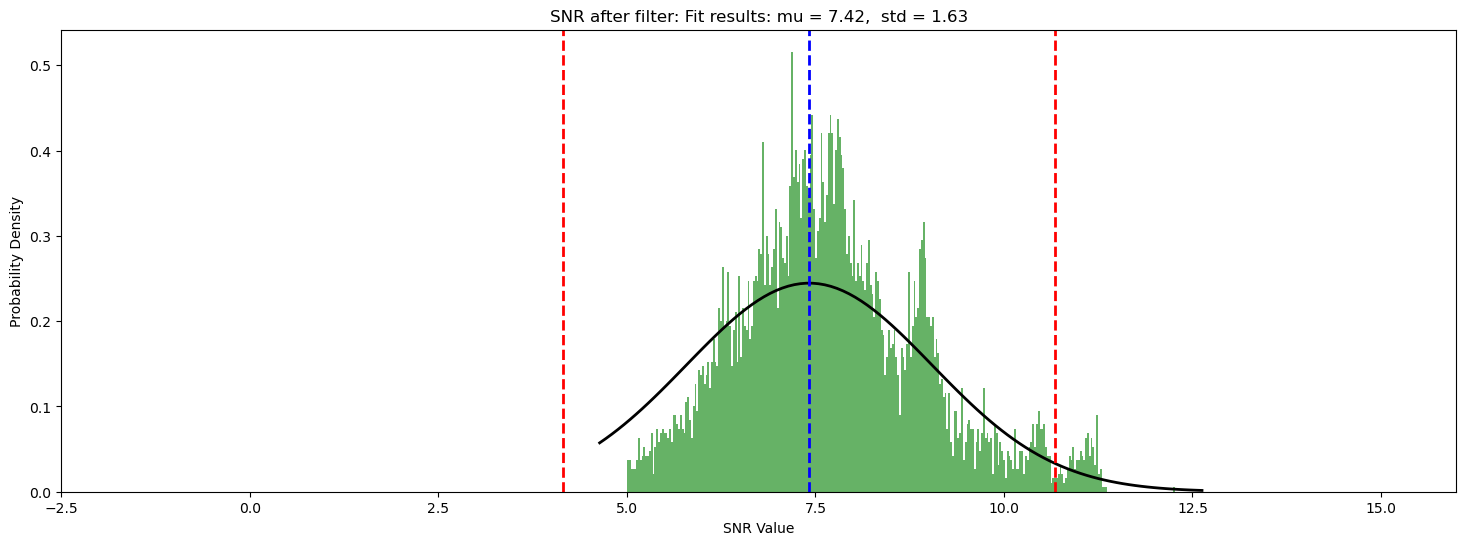

In [37]:
from scipy.stats import norm

# Plot the histogram
plt.figure(figsize=(18,6))
count, bins, ignored = plt.hist(chunks_df['snr'], bins=300, density=True, alpha=0.6, color='g')

# Fit a normal distribution to the data
mu, std = norm.fit(snr_list)

# Plot the Gaussian distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.axvline(mu , color='blue', linestyle='dashed', linewidth=2)
plt.axvline(mu - 2*std, color='r', linestyle='dashed', linewidth=2)
plt.axvline(mu + 2*std, color='r', linestyle='dashed', linewidth=2)
plt.xlim((-2.5,16))
title = f"SNR after filter: Fit results: mu = {mu:.2f},  std = {std:.2f}"
plt.title(title)

plt.xlabel('SNR Value')
plt.ylabel('Probability Density')
plt.show()

# Modeliing

In [ ]:
# Drop rows where 'Mean Respiration Rate' is NaN
chunks_df = chunks_df.dropna(subset=['Mean Respiration Rate'])

# Convert 'ecg' column to a 3D numpy array
X = np.array(chunks_df['ecg'].tolist())
y = chunks_df['Mean Respiration Rate'].values

# Normalize each ECG chunk individually and handle NaNs
X_normalized = np.zeros_like(X)
for i in range(X.shape[0]):
    mean = np.mean(X[i])
    std = np.std(X[i])
    if std == 0:  # Avoid division by zero
        std = 1
    X_normalized[i] = (X[i] - mean) / std

# Identify rows with NaNs in the normalized data
nan_rows = np.isnan(X_normalized).any(axis=1)

# Remove rows with NaNs
X_normalized = X_normalized[~nan_rows]
y = y[~nan_rows]
cleaned_chunks_df = chunks_df[~nan_rows]
# Check again for NaN values in normalized data
print(f"NaN in X_normalized after cleaning: {np.isnan(X_normalized).sum()}, Inf in X_normalized: {np.isinf(X_normalized).sum()}")

In [ ]:
# Calculate the 2.5th and 97.5th percentiles
lower_percentile = np.percentile(y, 0.5)
upper_percentile = np.percentile(y, 99.5)



# Verify the clipping
print(f"1th percentile: {lower_percentile}")
print(f"99th percentile: {upper_percentile}")
print(f"Before clipping: min = {y.min()}, max = {y.max()}")
# Clip the values in y_train
y = np.clip(y, lower_percentile, upper_percentile)
print(f"After clipping: min = {y.min()}, max = {y.max()}")

# Continue with training the model using y_train_clipped

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data by subjects
subjects = cleaned_chunks_df['subject_id'].unique()

# First, split subjects into training + validation, and test subjects
train_val_subjects, test_subjects = train_test_split(subjects, test_size=0.25, random_state=42)

# Now split the training + validation subjects to create a training set and validation set
train_subjects, val_subjects = train_test_split(train_val_subjects, test_size=0.15, random_state=42)

# Create boolean masks for train, validation, and test subjects
train_mask = cleaned_chunks_df['subject_id'].isin(train_subjects)
val_mask = cleaned_chunks_df['subject_id'].isin(val_subjects)
test_mask = cleaned_chunks_df['subject_id'].isin(test_subjects)

# Use these masks to create the actual train, validation, and test datasets
train_data = cleaned_chunks_df[train_mask]
val_data = cleaned_chunks_df[val_mask]
test_data = cleaned_chunks_df[test_mask]

# Now you have train, validation, and test datasets based on the subjects


In [ ]:
# Apply the masks to create train, validation, and test sets
X_train = np.expand_dims(X_normalized[train_mask], 2)
y_train = y[train_mask] 
X_val = np.expand_dims(X_normalized[val_mask], 2)
y_val = y[val_mask]
X_test = np.expand_dims(X_normalized[test_mask], 2)
y_test = y[test_mask]

# Print shapes of the datasets to verify
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")


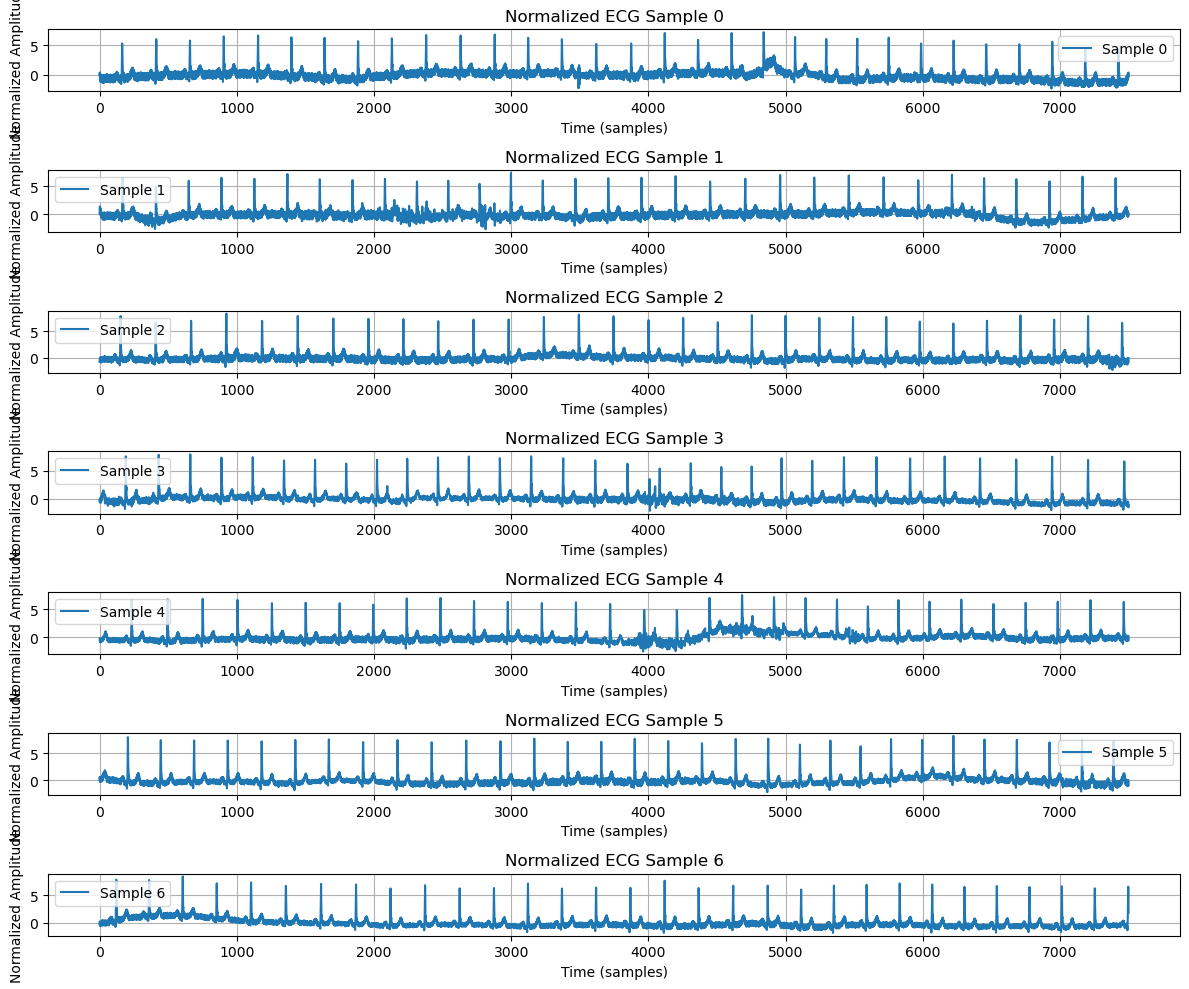

In [59]:
# Plot the first few samples of normalized ECG data in separate subplots
num_samples_to_plot = 7  # Number of samples to plot
fig, axs = plt.subplots(num_samples_to_plot, 1, figsize=(12, 10))

for i in range(num_samples_to_plot):
    axs[i].plot(X_normalized[i], label=f'Sample {i}')
    axs[i].set_title(f'Normalized ECG Sample {i}')
    axs[i].set_xlabel('Time (samples)')
    axs[i].set_ylabel('Normalized Amplitude')
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.show()

In [60]:
len(y_test)

1840

In [61]:
len(y_train)

5591

In [64]:
# Define the model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1)  # Output layer for regression
])

In [65]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Compile the model with a smaller learning rate
model.compile(optimizer=Adam(learning_rate=0.00001), loss='mean_absolute_error', metrics=['mae'])

# Print the model summary
model.summary()

# Train the model with the validation data
history = model.fit(X_train, y_train, epochs=25, batch_size=64, validation_data=(X_val, y_val))

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model with MSE and MAE
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Test MSE: {mse}")
print(f"Test MAE: {mae}")


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 7498, 64)          256       
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 3749, 64)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 3747, 128)         24704     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 1873, 128)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 239744)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               30687360  
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)              

2024-06-26 02:29:57.410840: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 167730000 exceeds 10% of free system memory.


Epoch 1/25


2024-06-26 02:29:58.197306: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2024-06-26 02:29:59.086848: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2024-06-26 02:30:02.774779: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2024-06-26 02:30:03.501409: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


88/88 [==============================] - 69s 457ms/step - loss: 9.4202 - mae: 9.4202 - val_loss: 4.0197 - val_mae: 4.0197
Epoch 2/25
88/88 [==============================] - 2s 24ms/step - loss: 3.8477 - mae: 3.8477 - val_loss: 2.7542 - val_mae: 2.7542
Epoch 3/25
88/88 [==============================] - 2s 23ms/step - loss: 3.3615 - mae: 3.3615 - val_loss: 2.6000 - val_mae: 2.6000
Epoch 4/25
88/88 [==============================] - 2s 23ms/step - loss: 3.3417 - mae: 3.3417 - val_loss: 2.3892 - val_mae: 2.3892
Epoch 5/25
88/88 [==============================] - 2s 23ms/step - loss: 3.2695 - mae: 3.2695 - val_loss: 2.3624 - val_mae: 2.3624
Epoch 6/25
88/88 [==============================] - 2s 23ms/step - loss: 3.2094 - mae: 3.2094 - val_loss: 2.3596 - val_mae: 2.3596
Epoch 7/25
88/88 [==============================] - 2s 23ms/step - loss: 3.1290 - mae: 3.1290 - val_loss: 2.3341 - val_mae: 2.3341
Epoch 8/25
88/88 [==============================] - 2s 23ms/step - loss: 3.1380 - mae: 3.138

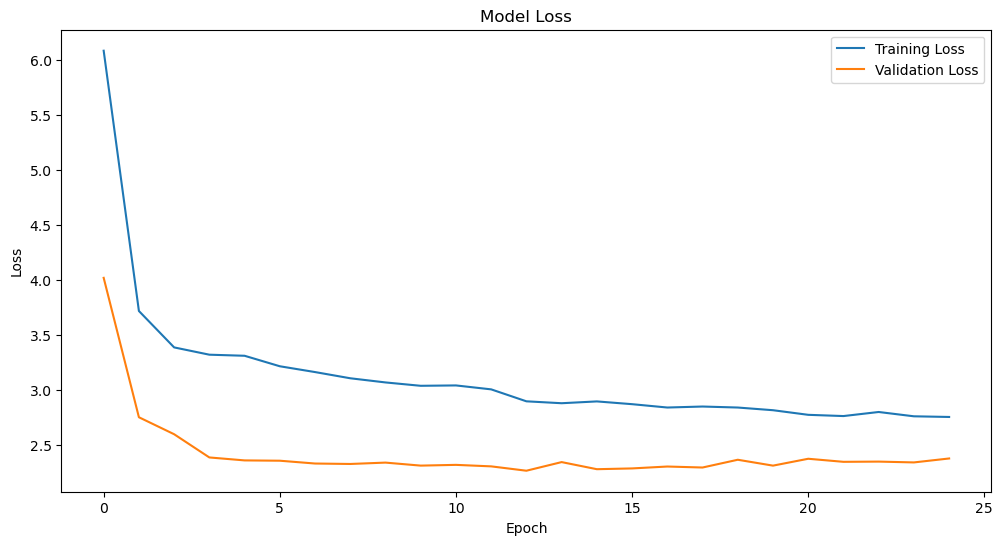

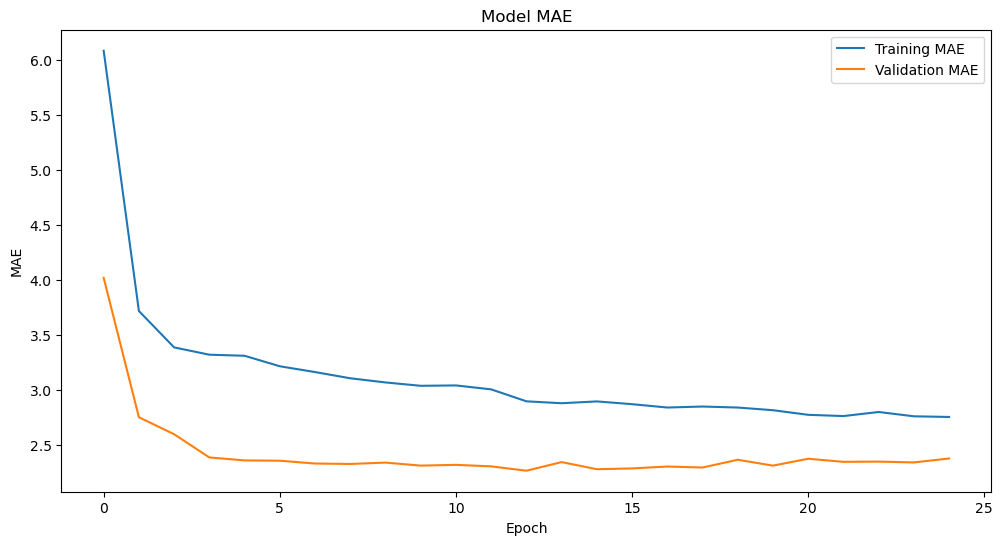

In [66]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Plot training & validation MAE values
plt.figure(figsize=(12, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


Pearson Correlation: 0.276588183638354
P-value: 1.1511692929463195e-33


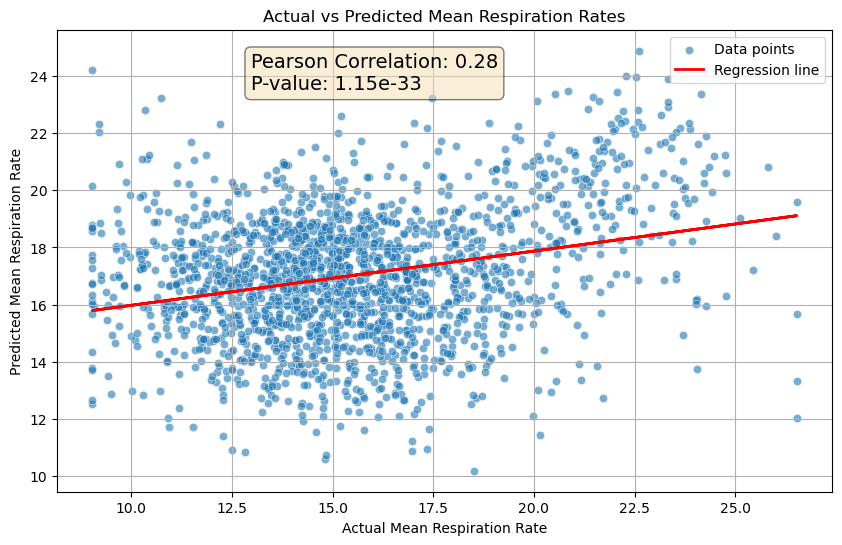

In [67]:
from scipy.stats import pearsonr, linregress

# Calculate the Pearson correlation coefficient
correlation, p_value = pearsonr(y_test, y_pred.flatten())
print(f"Pearson Correlation: {correlation}")
print(f"P-value: {p_value}")

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred.flatten(), alpha=0.6, edgecolors='w', linewidth=0.5, label='Data points')

# Calculate the regression line
slope, intercept, r_value, p_value, std_err = linregress(y_test, y_pred.flatten())
regression_line = slope * y_test + intercept
plt.plot(y_test, regression_line, color='red', linewidth=2, label='Regression line')

plt.title('Actual vs Predicted Mean Respiration Rates')
plt.xlabel('Actual Mean Respiration Rate')
plt.ylabel('Predicted Mean Respiration Rate')
plt.grid(True)
plt.legend()

# Add text box with correlation and p-value
textstr = f'Pearson Correlation: {correlation:.2f}\nP-value: {p_value:.2e}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.gca().text(0.25, 0.95, textstr, transform=plt.gca().transAxes, fontsize=14,
               verticalalignment='top', bbox=props)

plt.show()


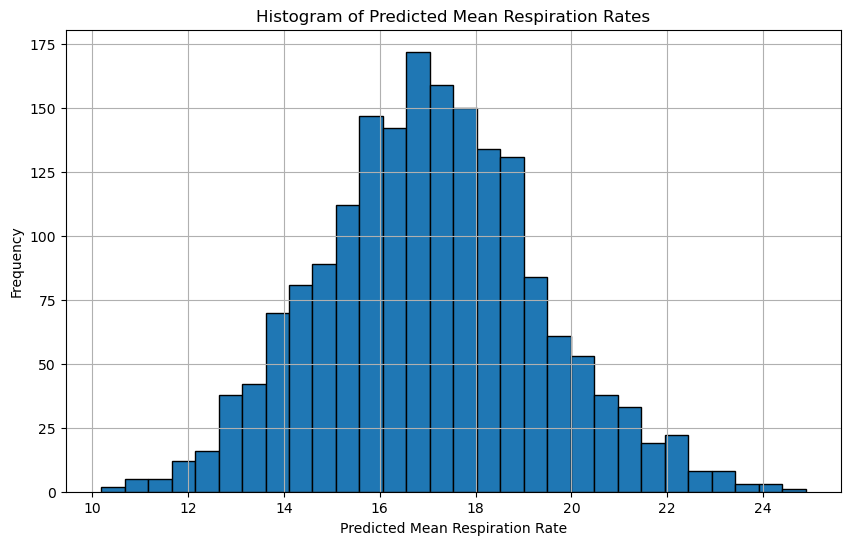

In [68]:
# Plot a histogram of the predicted mean respiration rates
plt.figure(figsize=(10, 6))
plt.hist(y_pred, bins=30, edgecolor='black')
plt.title('Histogram of Predicted Mean Respiration Rates')
plt.xlabel('Predicted Mean Respiration Rate')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

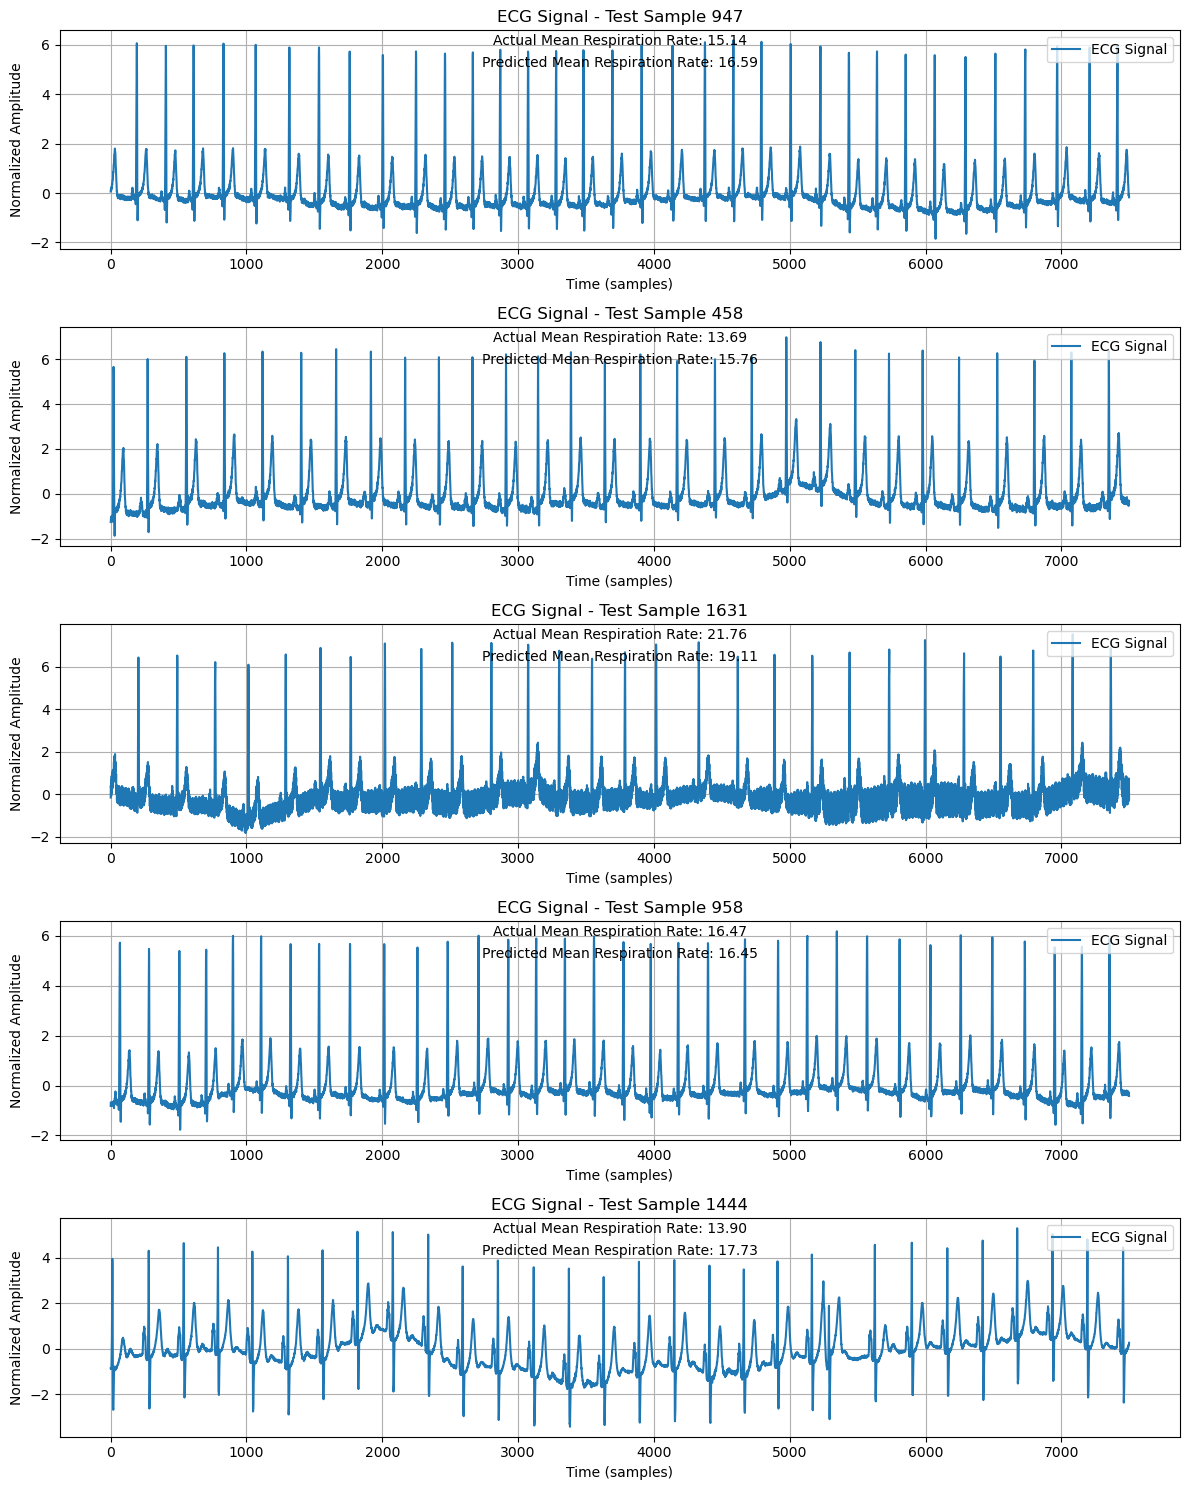

In [69]:
# Predict on the test set
y_pred = model.predict(X_test)

# Shuffle and select a few examples from the test set
num_examples_to_plot = 5
indices = np.arange(X_test.shape[0])
np.random.shuffle(indices)
selected_indices = indices[:num_examples_to_plot]

# Plot the selected examples from the test set
fig, axs = plt.subplots(num_examples_to_plot, 1, figsize=(12, 15))

for i, idx in enumerate(selected_indices):
    axs[i].plot(X_test[idx].flatten(), label='ECG Signal')
    axs[i].set_title(f'ECG Signal - Test Sample {idx}')
    axs[i].set_xlabel('Time (samples)')
    axs[i].set_ylabel('Normalized Amplitude')
    axs[i].legend(loc='upper right')
    axs[i].text(0.5, 0.95, f'Actual Mean Respiration Rate: {y_test[idx]:.2f}', horizontalalignment='center', verticalalignment='center', transform=axs[i].transAxes)
    axs[i].text(0.5, 0.85, f'Predicted Mean Respiration Rate: {y_pred[idx][0]:.2f}', horizontalalignment='center', verticalalignment='center', transform=axs[i].transAxes)
    axs[i].grid(True)

plt.tight_layout()
plt.show()